# BUILT Models

## Analisi esplorativa

In [ ]:
# ===================================================================
# GRUPPO 1: LIBRERIE STANDARD E DI SISTEMA
# ===================================================================
import os

# ===================================================================
# GRUPPO 2: LIBRERIE DI DATA SCIENCE E PLOTTING
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================================
# GRUPPO 3: LIBRERIE GEOSPAZIALI
# ===================================================================
import geopandas as gpd
from shapely.geometry import Point

# ===================================================================
# GRUPPO 4: LIBRERIE DI MACHINE LEARNING (SCIKIT-LEARN)
# ===================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    r2_score, 
    mean_squared_error,
    confusion_matrix # Importata qui per un uso generale se necessario
)
from sklearn.ensemble import RandomForestRegressor
# ===================================================================
# GRUPPO 5: LIBRERIE DI DEEP LEARNING (PYTORCH)
# ===================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ===================================================================
# GRUPPO 6: IMPORT DEGLI SCRIPT PERSONALIZZATI (.py)
# ===================================================================

# --- Script di utility e preprocessing ---
import nuovo_preprocessing
import analisi_funzioni

# --- Modelli Scikit-Learn Base ---
from models import (
    create_preprocessor,
    train_regression_model,
    train_classification_model
    # Le funzioni save/load model sono in entrambi i file, le importiamo da tuned
)

# --- Modelli Scikit-Learn con Tuning ---
from models_tuned import (
    train_tuned_regression_model,
    train_tuned_classification_model,
    save_model, # Funzione per salvare i modelli
    load_model  # Funzione per caricare i modelli
)

# --- Modelli PyTorch Base ---
from pytorch_models import (
    TabularDataset,
    RegressionNN,
    ClassificationNN,
    train_model, # Funzione di addestramento generica per PyTorch
    evaluate_regression,
    evaluate_classification
)

# --- Modelli PyTorch Potenziati (Enhanced) ---
from pytorch_models_enhanced import (
    RegressionNN_v2,
    ClassificationNN_v2
)
# Nota: le funzioni di utility (TabularDataset, train_model, etc.) sono le stesse
# del file base, quindi non è necessario re-importarle da qui.

# --- Modelli Geospaziali ---
import geospatial_models as gm

print("Tutte le librerie e i moduli personalizzati sono stati importati con successo.")


Tutte le librerie e i moduli personalizzati sono stati importati con successo.


In [13]:
# Impostazioni di visualizzazione
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

### Caricamento dati

In [14]:
# Definisci il percorso alla cartella principale
cartella_dati = "C:/Users/emmal/Desktop/STAGE/PROGETTO/DatiOMI/VERONA_prov"

# Definisci la colonna di join (nome della zona)
colonna_join_geo = 'zona'

# Esegui la funzione per caricare i dati separatamente
df_tabulare, gdf_geospaziale = nuovo_preprocessing.carica_dati_separati(
    cartella_dati=cartella_dati,
    zona_col_name=colonna_join_geo
)

# --- PRIMA ISPEZIONE DEI DATI ---
print("\n--- Informazioni sul DataFrame Tabulare ---")
print(f"Shape: {df_tabulare.shape}")
print(df_tabulare.head())

if gdf_geospaziale is not None and not gdf_geospaziale.empty:
    print("\n--- Informazioni sul GeoDataFrame Geospaziale ---")
    print(f"Shape: {gdf_geospaziale.shape}")
    print(gdf_geospaziale.head())
    # Controlla che sia effettivamente un GeoDataFrame
    print(f"Tipo di oggetto geospaziale: {type(gdf_geospaziale)}")
else:
    print("\nNessun dato geospaziale è stato caricato.")

--- Inizio scansione della cartella dati: C:/Users/emmal/Desktop/STAGE/PROGETTO/DatiOMI/VERONA_prov ---
Trovati 10 file VALORI, 10 file ZONE, e 686 file KML.
Concatenazione di 686 geometrie KML...
Inizio pulizia dati su DataFrame di shape (11681, 37)...


c:\Users\emmal\Desktop\STAGE\PROGETTO\MatterOfDesign\BuiltModels\nuovo_preprocessing.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='ignore')
c:\Users\emmal\Desktop\STAGE\PROGETTO\MatterOfDesign\BuiltModels\nuovo_preprocessing.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='ignore')
c:\Users\emmal\Desktop\STAGE\PROGETTO\MatterOfDesign\BuiltModels\nuovo_preprocessing.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), 

Pulizia dati completata.
Colonne con valore unico rimosse (escluse quelle protette): ['area_territoriale_val', 'regione_val', 'prov_val', 'sez_val', 'sup_nl_compr', 'area_territoriale_zone', 'regione_zone', 'prov_zone', 'sez_zone']
Inizio pulizia dati su DataFrame di shape (2100, 4)...
Pulizia dati completata.

Preprocessing completato per entrambi i DataFrame.

--- Informazioni sul DataFrame Tabulare ---
Shape: (11681, 28)
   comune_istat_val comune_cat_val comune_amm_val comune_descrizione_val  \
0           5023091           D6AA           L781                 VERONA   
1           5023091           D6AA           L781                 VERONA   
2           5023091           D6AA           L781                 VERONA   
3           5023091           D6AA           L781                 VERONA   
4           5023091           D6AA           L781                 VERONA   

  fascia_val zona_val    linkzona  cod_tip               descr_tipologia  \
0          B       B2  VR00000844      

### Statistiche Descrittive Iniziali

In [15]:
# --- STATISTICHE DESCRITTIVE ---

# Statistiche per le principali colonne numeriche (incluse quelle nuove geospaziali)
colonne_numeriche_chiave = [
    'compr_min', 'compr_max', 'loc_min', 'loc_max',
    'area_zona_mq', 'perimetro_zona_m', 'distanza_centro_m'
]
# Filtra per le colonne effettivamente presenti
colonne_numeriche_chiave = [col for col in colonne_numeriche_chiave if col in df_tabulare.columns]

print("\nStatistiche descrittive per le colonne numeriche chiave:")
print(df_tabulare[colonne_numeriche_chiave].describe().round(2))

# Conteggio per le principali colonne categoriche
print("\nConteggio per 'descr_tipologia':")
print(df_tabulare['descr_tipologia'].value_counts())

print("\nConteggio per 'stato':")
print(df_tabulare['stato'].value_counts())


Statistiche descrittive per le colonne numeriche chiave:
       compr_min  compr_max
count   11681.00   11681.00
mean      977.46    1370.32
std       518.78     755.31
min       280.00     370.00
25%       660.00     920.00
50%       890.00    1200.00
75%      1150.00    1600.00
max      5000.00    7300.00

Conteggio per 'descr_tipologia':
descr_tipologia
Abitazioni civili               2815
Ville e Villini                 2474
Uffici                          1713
Negozi                          1711
Capannoni tipici                1544
Abitazioni di tipo economico    1122
Box                              110
Magazzini                         81
Laboratori                        71
Capannoni industriali             40
Name: count, dtype: int64

Conteggio per 'stato':
stato
NORMALE     10222
OTTIMO       1439
SCADENTE       20
Name: count, dtype: int64


### Analisi Univariata - Distribuzione Feature Numeriche

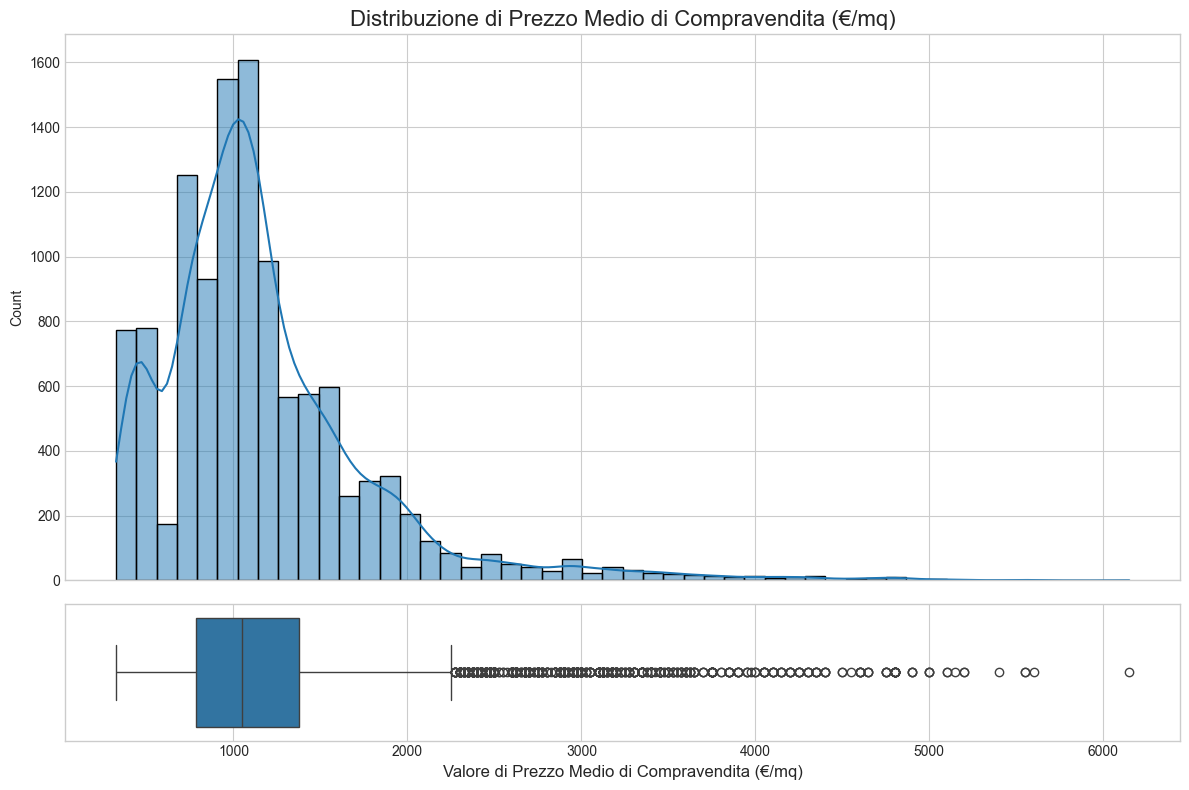

In [16]:
# --- ANALISI UNIVARIATA NUMERICA ---
# Usiamo la funzione creata in analisi_funzioni.py

# Aggiungi una colonna con il prezzo medio per mq per le analisi
df_tabulare['prezzo_medio_mq'] = (df_tabulare['compr_min'] + df_tabulare['compr_max']) / 2

# Visualizza la distribuzione del prezzo medio
analisi_funzioni.plot_distribuzione_numerica(
    df_tabulare,
    colonna='prezzo_medio_mq',
    titolo='Prezzo Medio di Compravendita (€/mq)'
)

# Visualizza la distribuzione della distanza dal centro
if 'distanza_centro_m' in df_tabulare.columns:
    analisi_funzioni.plot_distribuzione_numerica(
        df_tabulare.dropna(subset=['distanza_centro_m']), # Usa solo i dati con geometria
        colonna='distanza_centro_m',
        titolo='Distanza dal Centro (metri)'
    )

### Distribuzione Feature Categoriche

C:\Users\emmal\AppData\Local\Temp\ipykernel_7888\729812024.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_tabulare['descr_tipologia'], order=df_tabulare['descr_tipologia'].value_counts().index, palette='viridis')


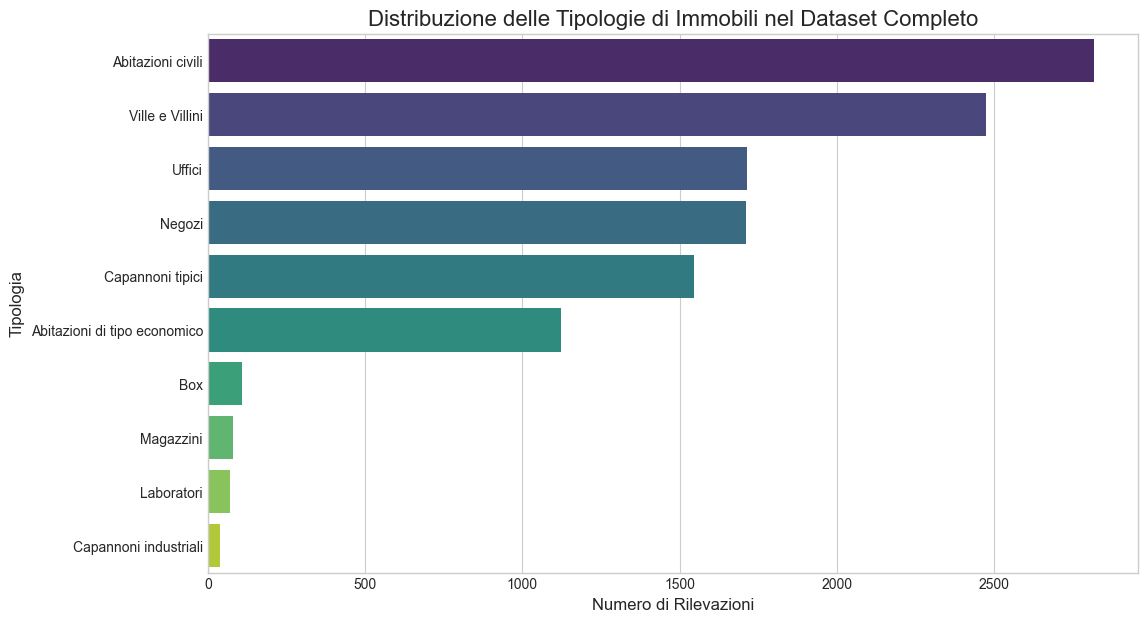

C:\Users\emmal\AppData\Local\Temp\ipykernel_7888\729812024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_tabulare['stato'], order=df_tabulare['stato'].value_counts().index, palette='plasma')


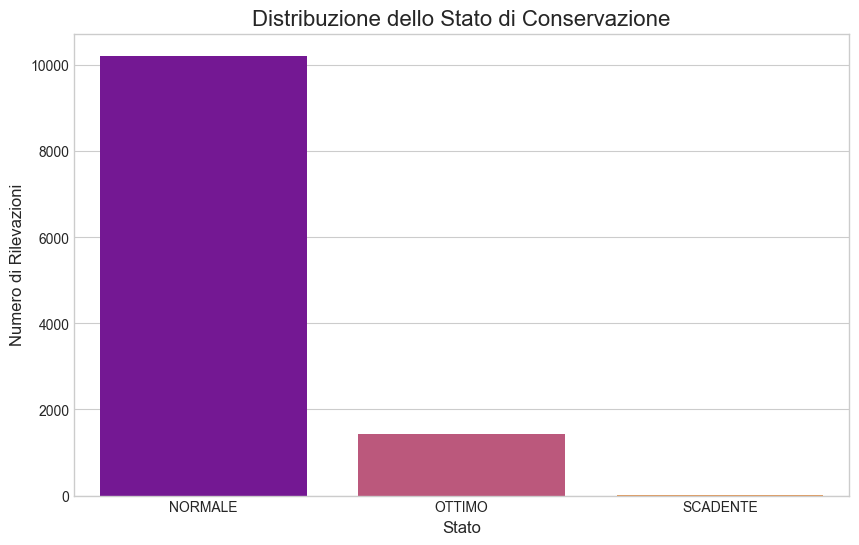

In [17]:
# --- ANALISI UNIVARIATA CATEGORICA ---

# Distribuzione delle Tipologie di Immobili
plt.figure(figsize=(12, 7))
sns.countplot(y=df_tabulare['descr_tipologia'], order=df_tabulare['descr_tipologia'].value_counts().index, palette='viridis')
plt.title('Distribuzione delle Tipologie di Immobili nel Dataset Completo', fontsize=16)
plt.xlabel('Numero di Rilevazioni', fontsize=12)
plt.ylabel('Tipologia', fontsize=12)
plt.show()

# Distribuzione dello Stato di Conservazione
plt.figure(figsize=(10, 6))
sns.countplot(x=df_tabulare['stato'], order=df_tabulare['stato'].value_counts().index, palette='plasma')
plt.title('Distribuzione dello Stato di Conservazione', fontsize=16)
plt.xlabel('Stato', fontsize=12)
plt.ylabel('Numero di Rilevazioni', fontsize=12)
plt.show()

### Analisi Bivariata e Temporale

C:\Users\emmal\AppData\Local\Temp\ipykernel_7888\2749846850.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prezzo_medio_mq', y='descr_tipologia', data=df_tabulare, order=df_tabulare.groupby('descr_tipologia')['prezzo_medio_mq'].median().sort_values().index, palette='coolwarm')


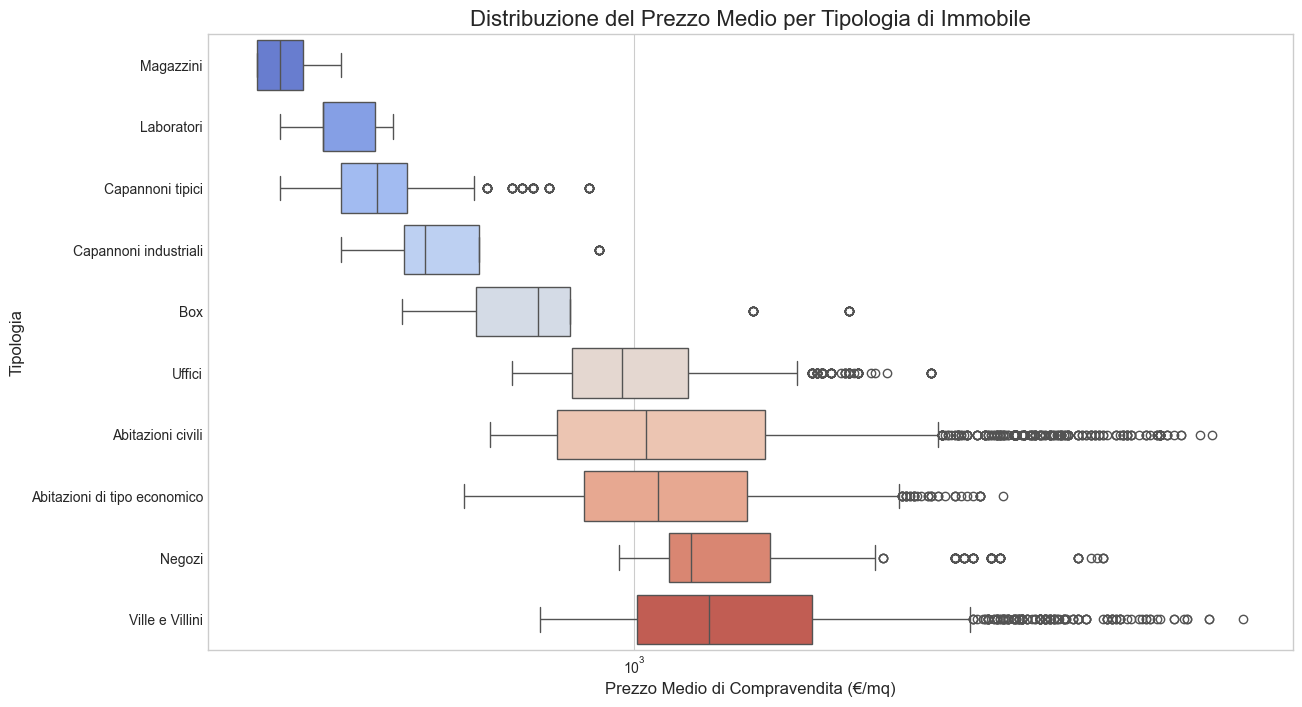

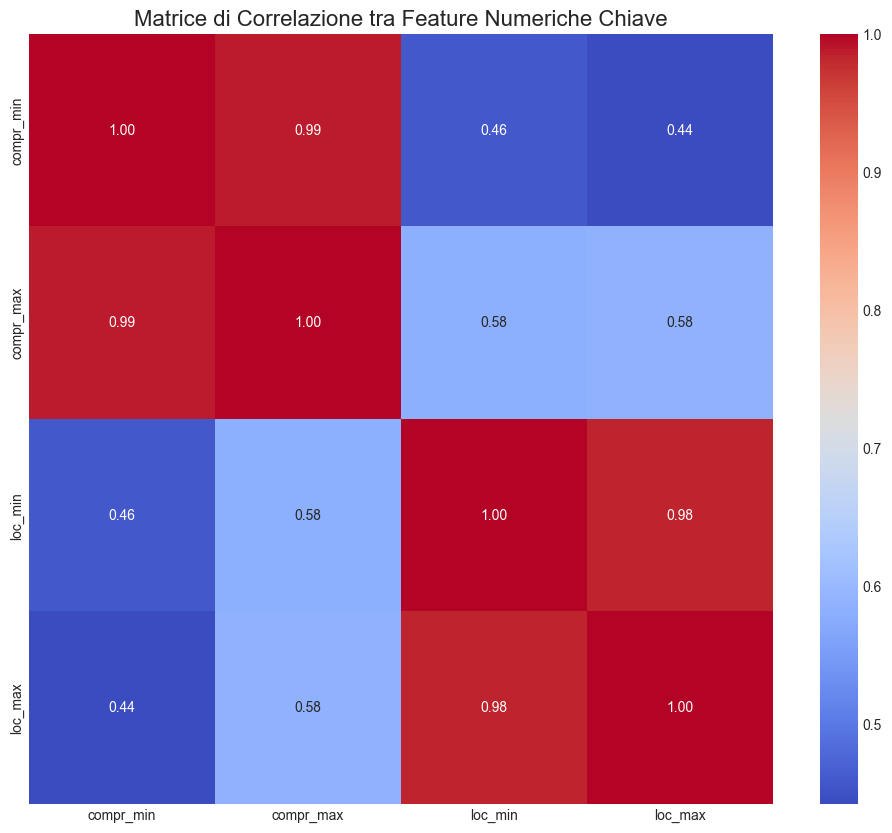

In [18]:
# --- ANALISI BIVARIATA E TEMPORALE ---

# Boxplot: Prezzo medio per tipologia di immobile
plt.figure(figsize=(14, 8))
sns.boxplot(x='prezzo_medio_mq', y='descr_tipologia', data=df_tabulare, order=df_tabulare.groupby('descr_tipologia')['prezzo_medio_mq'].median().sort_values().index, palette='coolwarm')
plt.title('Distribuzione del Prezzo Medio per Tipologia di Immobile', fontsize=16)
plt.xlabel('Prezzo Medio di Compravendita (€/mq)', fontsize=12)
plt.ylabel('Tipologia', fontsize=12)
plt.xscale('log') # Usa scala logaritmica se i valori sono molto schiacciati
plt.show()

# Analisi Temporale: Andamento del prezzo medio nel tempo
# Assicurati di avere le colonne 'anno' e 'semestre_num' dal preprocessing
if 'anno' in df_tabulare.columns and 'semestre_num' in df_tabulare.columns:
    df_tabulare['periodo'] = df_tabulare['anno'].astype(str) + ' - Semestre ' + df_tabulare['semestre_num'].astype(str)
    
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='periodo', y='prezzo_medio_mq', data=df_tabulare, hue='descr_tipologia', marker='o', errorbar=None)
    plt.title('Andamento del Prezzo Medio (€/mq) nel Tempo per Tipologia', fontsize=16)
    plt.xlabel('Periodo', fontsize=12)
    plt.ylabel('Prezzo Medio (€/mq)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Tipologia', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Matrice di Correlazione per le feature numeriche
plt.figure(figsize=(12, 10))
matrice_correlazione = df_tabulare[colonne_numeriche_chiave].corr()
sns.heatmap(matrice_correlazione, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione tra Feature Numeriche Chiave', fontsize=16)
plt.show()

# Analisi Geospaziale - Preparazione e Mappe

In [19]:
# --- CELLA DI DEBUG DEFINITIVA PER IL FILE SYSTEM ---

# Assicurati che questa variabile sia definita correttamente con il tuo percorso
cartella_dati = "C:/Users/emmal/Desktop/STAGE/PROGETTO/DatiOMI/VERONA_prov"
print(f"--- INIZIO DEBUG DETTAGLIATO DEL PERCORSO: '{cartella_dati}' ---")

# 1. Verifica che il percorso esista
if not os.path.exists(cartella_dati):
    print("\nERRORE FATALE: Il percorso specificato non esiste. Controlla che non ci siano errori di battitura.")
elif not os.path.isdir(cartella_dati):
    print(f"\nERRORE FATALE: Il percorso '{cartella_dati}' punta a un file, non a una cartella.")
else:
    print("\nSUCCESSO: Il percorso punta a una cartella esistente.")
    
    # 2. Lista tutto il contenuto della cartella principale
    print("\n--- Contenuto trovato nella cartella principale ---")
    elementi_trovati = os.listdir(cartella_dati)
    
    if not elementi_trovati:
        print("ATTENZIONE: La cartella è vuota!")
    else:
        for nome_elemento in elementi_trovati:
            path_elemento = os.path.join(cartella_dati, nome_elemento)
            
            # 3. Per ogni elemento, determina se è un file o una cartella
            if os.path.isdir(path_elemento):
                print(f"  -> [CARTELLA] {nome_elemento}")
                # Prova a vedere cosa c'è dentro
                try:
                    contenuto_sottocartella = os.listdir(path_elemento)
                    print(f"     Contenuto: {contenuto_sottocartella[:5]} {'...' if len(contenuto_sottocartella) > 5 else ''}")
                except Exception as e:
                    print(f"     Impossibile leggere il contenuto: {e}")

            elif os.path.isfile(path_elemento):
                print(f"  -> [FILE]     {nome_elemento}")
            else:
                print(f"  -> [SCONOSCIUTO] {nome_elemento}")

print("\n--- FINE DEBUG ---")

--- INIZIO DEBUG DETTAGLIATO DEL PERCORSO: 'C:/Users/emmal/Desktop/STAGE/PROGETTO/DatiOMI/VERONA_prov' ---

SUCCESSO: Il percorso punta a una cartella esistente.

--- Contenuto trovato nella cartella principale ---
  -> [FILE]     QIP_1201216_1_20232_VALORI.csv
  -> [FILE]     QIP_1201216_1_20232_ZONE.csv
  -> [FILE]     QIP_1201217_1_20222_VALORI.csv
  -> [FILE]     QIP_1201217_1_20222_ZONE.csv
  -> [FILE]     QIP_1201218_1_20221_VALORI.csv
  -> [FILE]     QIP_1201218_1_20221_ZONE.csv
  -> [FILE]     QIP_1201220_1_20212_VALORI.csv
  -> [FILE]     QIP_1201220_1_20212_ZONE.csv
  -> [FILE]     QIP_1201221_1_20211_VALORI.csv
  -> [FILE]     QIP_1201221_1_20211_ZONE.csv
  -> [FILE]     QIP_1201223_1_20202_VALORI.csv
  -> [FILE]     QIP_1201223_1_20202_ZONE.csv
  -> [FILE]     QIP_1201225_1_20201_VALORI.csv
  -> [FILE]     QIP_1201225_1_20201_ZONE.csv
  -> [FILE]     QI_1201235_1_20231_VALORI.csv
  -> [FILE]     QI_1201235_1_20231_ZONE.csv
  -> [FILE]     QI_1201237_1_20241_VALORI.csv
  -> 

Dati geospaziali caricati con successo.
Shape del GeoDataFrame: (2100, 4)

Semestri presenti nel GeoDataFrame:
['2020_1', '2020_2', '2021_1', '2021_2', '2022_1', '2022_2', '2023_2']

Controllo e correzione delle geometrie non valide in corso...
Correzione completata.
Aggregazione delle zone per la mappa di base...

Numero di zone uniche mappate: 347


<Figure size 1500x1500 with 0 Axes>

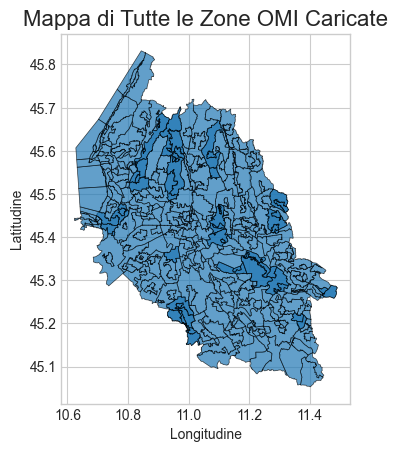

In [20]:
# --- ANALISI GEOSPAZIALE ---

if gdf_geospaziale is not None and not gdf_geospaziale.empty:
    print("Dati geospaziali caricati con successo.")
    print(f"Shape del GeoDataFrame: {gdf_geospaziale.shape}")
    print("\nSemestri presenti nel GeoDataFrame:")
    print(sorted(gdf_geospaziale['semestre'].unique()))

    # --- CORREZIONE DELLE GEOMETRIE NON VALIDE ---
    # L'operazione .buffer(0) è una tecnica standard per correggere errori topologici.
    # Applichiamola prima di operazioni complesse come .dissolve()
    print("\nControllo e correzione delle geometrie non valide in corso...")
    gdf_geospaziale['geometry'] = gdf_geospaziale.geometry.buffer(0)
    print("Correzione completata.")
    
    # --- Mappa di Base di TUTTE le Zone OMI Caricate ---
    # Ora che le geometrie sono pulite, il dissolve dovrebbe funzionare.
    print("Aggregazione delle zone per la mappa di base...")
    zone_unificate = gdf_geospaziale.dissolve(by='zona')
    
    print(f"\nNumero di zone uniche mappate: {len(zone_unificate)}")

    plt.figure(figsize=(15, 15))
    zone_unificate.plot(edgecolor='black', alpha=0.7, linewidth=0.5) # Aggiunto linewidth
    plt.title('Mappa di Tutte le Zone OMI Caricate', fontsize=16)
    plt.xlabel('Longitudine')
    plt.ylabel('Latitudine')
    plt.grid(True)
    plt.show()
else:
    print("Nessuna colonna 'geometry' valida trovata. Salto le analisi geospaziali.")

# Analisi Geospaziale - Mappe Tematiche (Choropleth)

## 1. COMPRAVENDITA

### Mappa di Previsione dei Prezzi

c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

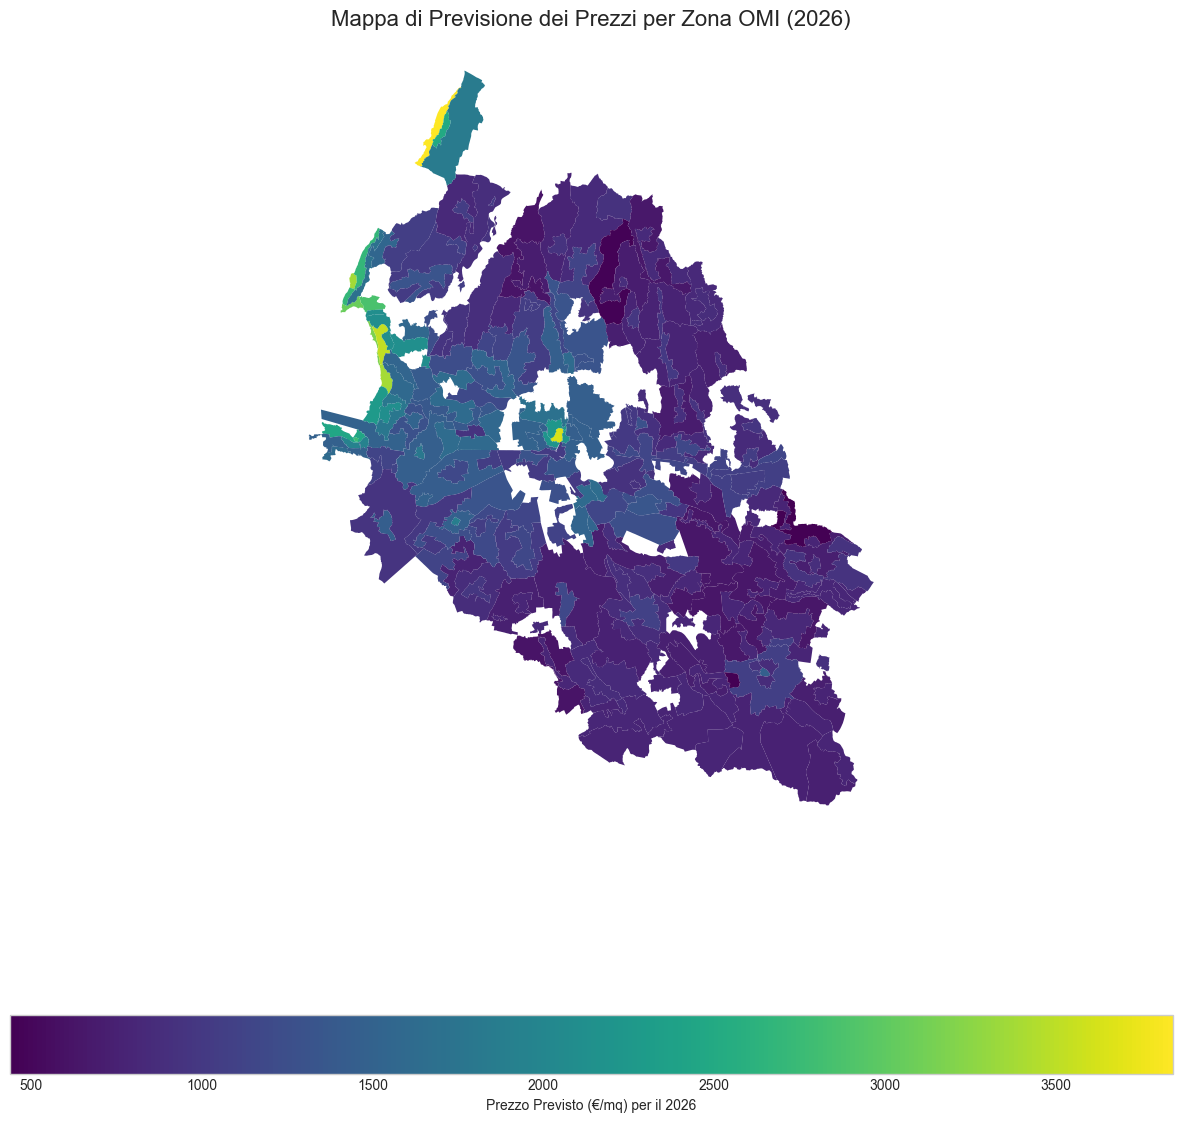

In [ ]:
# --- MAPPA DI PREVISIONE DEI PREZZI MEDI ---
# Aggiungi una colonna con il prezzo medio per mq per le analisi
df_tabulare['prezzo_medio_mq'] = (df_tabulare['compr_min'] + df_tabulare['compr_max']) / 2

# Assicurati che 'df_tabulare' e 'gdf_geospaziale' siano caricati e pronti
if 'df_tabulare' in locals() and 'gdf_geospaziale' in locals():

    # 1. PREPARA E UNISCI I DATI
    # Aggiungi la colonna 'prezzo_medio_mq' se non esiste già
    if 'prezzo_medio_mq' not in df_tabulare.columns:
        df_tabulare['prezzo_medio_mq'] = (df_tabulare['compr_min'] + df_tabulare['compr_max']) / 2
    
    # Crea una colonna 'zona' in df_tabulare per il join, basandoti sulla struttura di gdf_geospaziale
    # Esempio: "VERONA - Zona OMI B2"
    df_tabulare['zona'] = df_tabulare['comune_descrizione_val'] + ' - Zona OMI ' + df_tabulare['zona_val']

    # Unisci i dati tabulari con quelli geospaziali
    # Questo è il passaggio chiave che mancava
    gdf_completo = gdf_geospaziale.merge(df_tabulare, on=['zona', 'semestre'], how='left')

    # Rimuovi eventuali righe senza dati sui prezzi
    gdf_completo.dropna(subset=['prezzo_medio_mq'], inplace=True)

    # 2. FUNZIONE DI PREPARAZIONE DATI E PREVISIONE
    # Funzione per convertire il semestre in un valore numerico (es. '2023_2' -> 2023.5)
    def semestre_a_numero(s):
        anno, sem = s.split('_')
        return float(anno) + (0.5 if sem == '2' else 0.0)

    gdf_completo['periodo_num'] = gdf_completo['semestre'].apply(semestre_a_numero)

    # Dizionario per salvare le previsioni
    previsioni = {}
    
    # Anno/semestre per cui fare la previsione (es. primo semestre 2025 -> 2025.0)
    periodo_futuro = 2026.0

    # 3. CREA IL MODELLO E PREVEDI PER OGNI ZONA
    for zona, gruppo in gdf_completo.groupby('zona'):
        # Assicurati ci siano abbastanza dati per una regressione
        if len(gruppo) < 2:
            continue

        X = gruppo[['periodo_num']]
        y = gruppo['prezzo_medio_mq']

        model = RandomForestRegressor(n_estimators=50, random_state=42)
        model.fit(X, y)
        
        # Prevedi il prezzo per il periodo futuro
        previsione = model.predict(np.array([[periodo_futuro]]))
        previsioni[zona] = previsione[0]

    # 4. CREA LA MAPPA CON I DATI PREVISTI
    # Prendi le geometrie uniche delle zone
    zone_geometrie = gdf_geospaziale.dissolve(by='zona')
    
    # Crea una Series con le previsioni per il merge
    s_previsioni = pd.Series(previsioni, name=f'prezzo_previsto_{int(periodo_futuro)}')
    
    # Unisci le geometrie con le previsioni
    mappa_previsione = zone_geometrie.join(s_previsioni, how='inner')

    # Creazione della mappa
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    mappa_previsione.plot(
        column=f'prezzo_previsto_{int(periodo_futuro)}',
        ax=ax,
        legend=True,
        cmap='viridis',
        legend_kwds={'label': f"Prezzo Previsto (€/mq) per il {int(periodo_futuro)}", 'orientation': "horizontal"},
        missing_kwds={"color": "lightgrey", "label": "Dati insufficienti"}
    )
    ax.set_title(f'Mappa di Previsione dei Prezzi per Zona OMI ({int(periodo_futuro)})', fontsize=16)
    ax.set_axis_off()
    plt.show()

else:
    print("DataFrame 'df_tabulare' o 'gdf_geospaziale' non trovati. Assicurati di aver eseguito le celle precedenti.")


### Mappa per Tipologia di Abitazione Prevalente

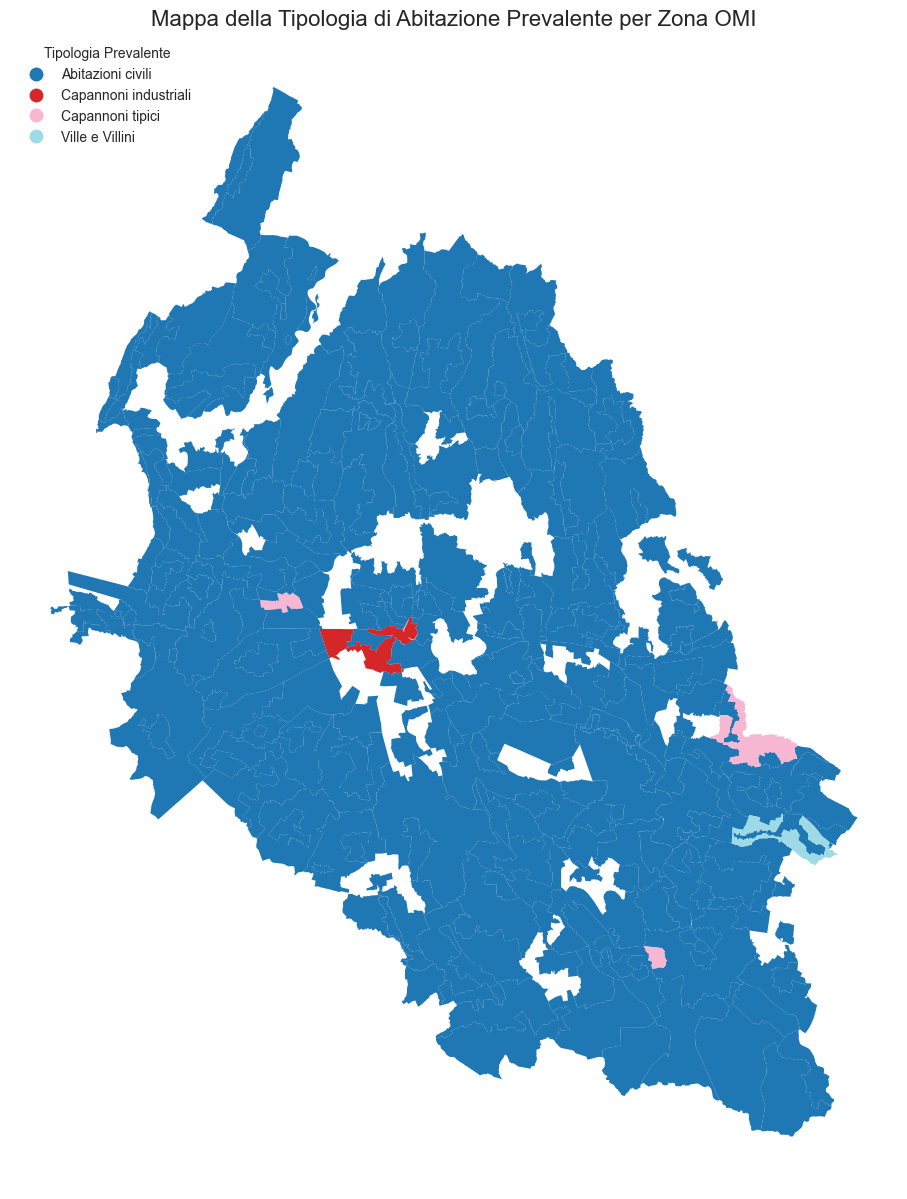

In [22]:
# Assicurati che il DataFrame unito 'gdf_completo' sia disponibile dalla cella precedente
if 'gdf_completo' in locals() and not gdf_completo.empty:

    # 1. AGGREGA I DATI PER TROVARE LA MODA
    # Per ogni zona, trova la tipologia di immobile più frequente (la moda)
    # Usiamo lambda perché la moda può restituire più valori; prendiamo il primo.
    dati_mappa_tipologia = gdf_completo.dissolve(
        by='zona',
        aggfunc={'descr_tipologia': lambda x: x.mode()[0] if not x.mode().empty else None}
    )
    dati_mappa_tipologia.dropna(subset=['descr_tipologia'], inplace=True)


    # 2. CREAZIONE DELLA MAPPA CATEGORICA
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    dati_mappa_tipologia.plot(
        column='descr_tipologia',
        ax=ax,
        legend=True,
        categorical=True,  # Impostazione chiave per dati testuali/categorici
        cmap='tab20',      # Colormap adatta a dati categorici
        legend_kwds={'title': "Tipologia Prevalente", 'loc': 'upper left'}
    )
    ax.set_title('Mappa della Tipologia di Abitazione Prevalente per Zona OMI', fontsize=16)
    ax.set_axis_off()
    plt.show()

else:
    print("DataFrame 'gdf_completo' non disponibile. Esegui la cella precedente per crearlo.")

### Mappa della Tipologia con la Maggior Crescita di Valore Prevista

c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

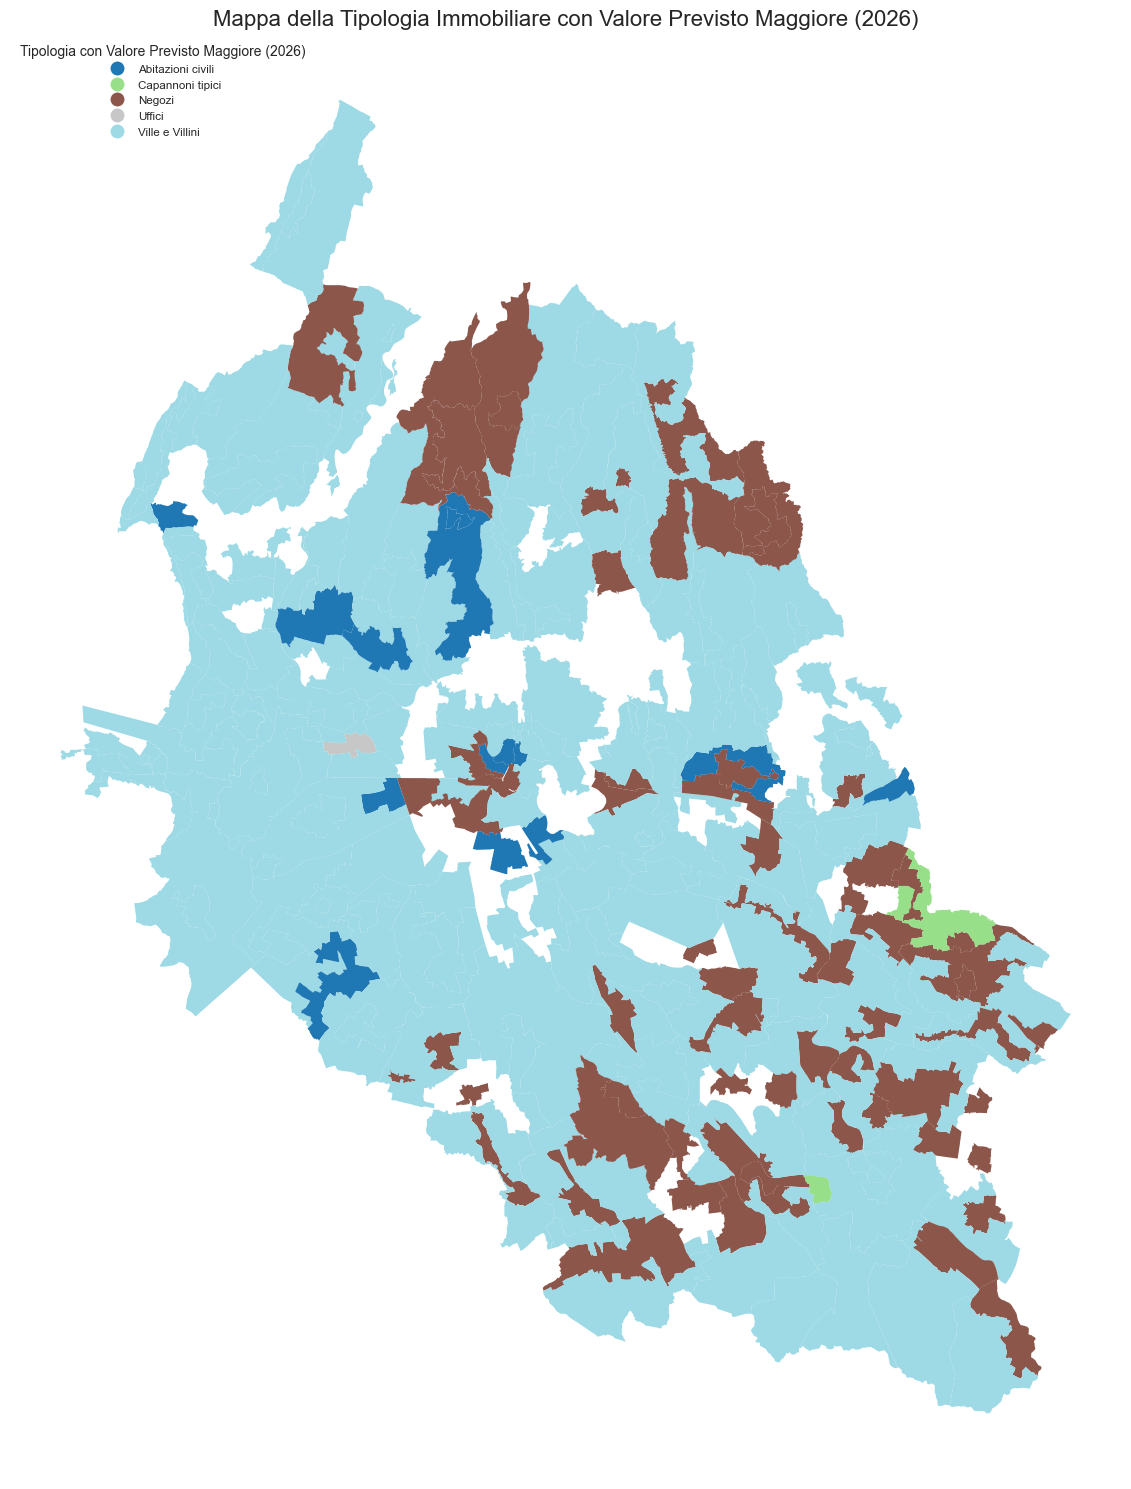

In [ ]:
# --- MAPPA DELLA TIPOLOGIA CON IL VALORE PREVISTO PIÙ ALTO (2026) ---
# Assicurati che 'gdf_completo' dalla cella precedente sia disponibile
if 'gdf_completo' in locals() and not gdf_completo.empty:

    # 1. PREPARA I DATI E IL PERIODO DI PREVISIONE
    periodo_futuro_2026 = 2026.0
    previsioni_per_tipologia = {}

    # 2. RAGGRUPPA, MODELLA E PREVEDI PER OGNI ZONA E TIPOLOGIA
    # Usiamo un ciclo annidato: prima per zona, poi per tipologia all'interno della zona
    for zona, dati_zona in gdf_completo.groupby('zona'):
        
        previsioni_in_zona = {}
        for tipologia, dati_tipologia in dati_zona.groupby('descr_tipologia'):
            
            # Assicurati ci siano abbastanza dati per una regressione
            if len(dati_tipologia) < 2:
                continue

            X = dati_tipologia[['periodo_num']]
            y = dati_tipologia['prezzo_medio_mq']

            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X, y)
            
            # Prevedi il prezzo per il 2026 per questa specifica tipologia
            previsione = model.predict(np.array([[periodo_futuro_2026]]))
            previsioni_in_zona[tipologia] = previsione[0]
        
        # Se abbiamo previsioni per questa zona, le salviamo
        if previsioni_in_zona:
            previsioni_per_tipologia[zona] = previsioni_in_zona

    # 3. IDENTIFICA LA TIPOLOGIA CON LA PREVISIONE PIÙ ALTA PER ZONA
    tipologia_leader_valore = {}
    for zona, previsioni in previsioni_per_tipologia.items():
        if previsioni: # Se ci sono previsioni per questa zona
            # Trova la tipologia con il valore massimo previsto
            tipologia_leader = max(previsioni, key=previsioni.get)
            tipologia_leader_valore[zona] = tipologia_leader

    # 4. CREA LA MAPPA CATEGORICA
    # Prendi le geometrie uniche delle zone
    zone_geometrie = gdf_geospaziale.dissolve(by='zona')
    
    # Crea una Series con le tipologie leader per il merge
    s_tipologia_leader = pd.Series(tipologia_leader_valore, name='tipologia_leader_2026')
    
    # Unisci le geometrie con i risultati
    mappa_previsione_tipologia = zone_geometrie.join(s_tipologia_leader, how='inner')

    # Creazione della mappa
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    mappa_previsione_tipologia.plot(
        column='tipologia_leader_2026',
        ax=ax,
        legend=True,
        categorical=True,
        cmap='tab20', # Colormap adatta per dati categorici
        legend_kwds={'title': "Tipologia con Valore Previsto Maggiore (2026)", 'loc': 'upper left', 'fontsize': 'small'},
        missing_kwds={"color": "lightgrey", "label": "Dati insufficienti per previsione"}
    )
    ax.set_title('Mappa della Tipologia Immobiliare con Valore Previsto Maggiore (2026)', fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

else:
    print("DataFrame 'gdf_completo' non disponibile. Esegui la cella precedente per crearlo.")

## 2. LOCAZIONE

### Mappa di Previsione dei Canoni di Locazione (2026)

c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

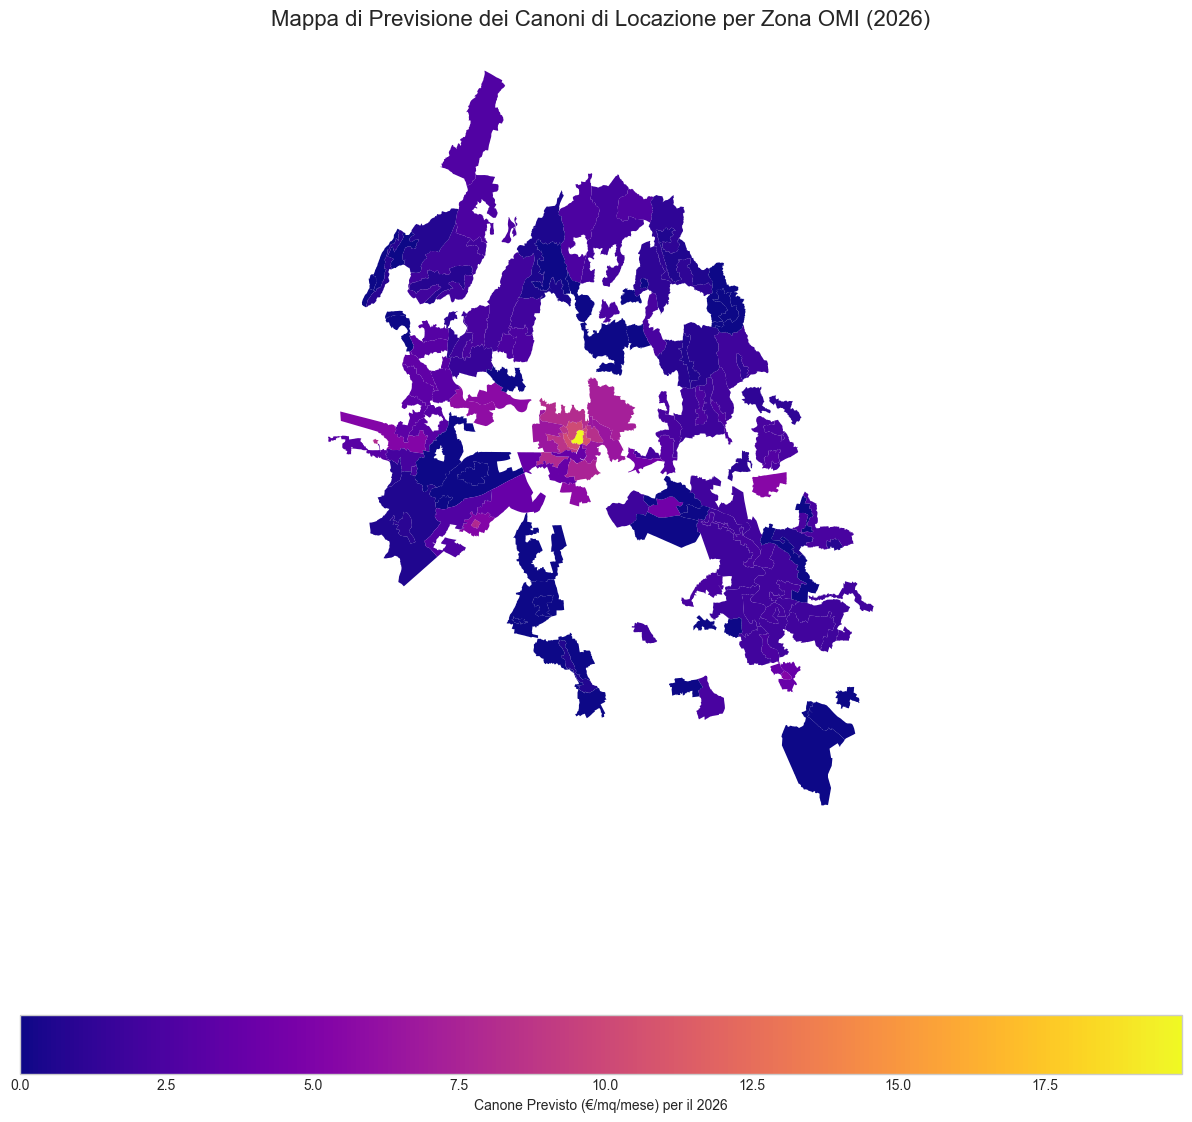

In [ ]:
# --- MAPPA DI PREVISIONE DEI CANONI DI LOCAZIONE (2026) ---
if 'df_tabulare' in locals() and 'gdf_geospaziale' in locals():

    # 1. PREPARA E UNISCI I DATI PER LA LOCAZIONE
    # Aggiungi la colonna 'locazione_media_mq'
    # Assicura che le colonne di locazione siano numeriche, convertendo errori in NaN
    df_tabulare['loc_min'] = pd.to_numeric(df_tabulare['loc_min'], errors='coerce')
    df_tabulare['loc_max'] = pd.to_numeric(df_tabulare['loc_max'], errors='coerce')
    
    df_tabulare['locazione_media_mq'] = (df_tabulare['loc_min'] + df_tabulare['loc_max']) / 2
    
    # Crea la colonna 'zona' per il join se non esiste già
    if 'zona' not in df_tabulare.columns:
        df_tabulare['zona'] = df_tabulare['comune_descrizione_val'] + ' - Zona OMI ' + df_tabulare['zona_val']

    # Unisci i dati
    gdf_completo_loc = gdf_geospaziale.merge(df_tabulare, on=['zona', 'semestre'], how='left')
    
    # !!! IMPORTANTE: Rimuovi le righe dove non ci sono dati di locazione
    gdf_completo_loc.dropna(subset=['locazione_media_mq'], inplace=True)

    # Converti il semestre in un valore numerico
    if 'periodo_num' not in gdf_completo_loc.columns:
        def semestre_a_numero(s):
            anno, sem = s.split('_')
            return float(anno) + (0.5 if sem == '2' else 0.0)
        gdf_completo_loc['periodo_num'] = gdf_completo_loc['semestre'].apply(semestre_a_numero)

    # 2. MODELLA E PREVEDI IL CANONE DI LOCAZIONE
    previsioni_locazione = {}
    periodo_futuro_2026 = 2026.0

    for zona, gruppo in gdf_completo_loc.groupby('zona'):
        if len(gruppo) < 2:
            continue

        X = gruppo[['periodo_num']]
        y = gruppo['locazione_media_mq']

        model = RandomForestRegressor(n_estimators=50, random_state=42)
        model.fit(X, y)
        
        previsione = model.predict(np.array([[periodo_futuro_2026]]))
        previsioni_locazione[zona] = previsione[0]

    # 3. CREA LA MAPPA DI PREVISIONE
    zone_geometrie = gdf_geospaziale.dissolve(by='zona')
    s_previsioni_loc = pd.Series(previsioni_locazione, name=f'locazione_prevista_2026')
    mappa_previsione_loc = zone_geometrie.join(s_previsioni_loc, how='inner')

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    mappa_previsione_loc.plot(
        column=f'locazione_prevista_2026',
        ax=ax,
        legend=True,
        cmap='plasma', # Cambiamo colormap per distinguerla
        legend_kwds={'label': "Canone Previsto (€/mq/mese) per il 2026", 'orientation': "horizontal"},
        missing_kwds={"color": "lightgrey", "label": "Dati insufficienti"}
    )
    ax.set_title('Mappa di Previsione dei Canoni di Locazione per Zona OMI (2026)', fontsize=16)
    ax.set_axis_off()
    plt.show()

else:
    print("DataFrame 'df_tabulare' o 'gdf_geospaziale' non trovati.")

### Mappa della Tipologia con il Canone di Locazione Previsto più Alto (2026)

c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

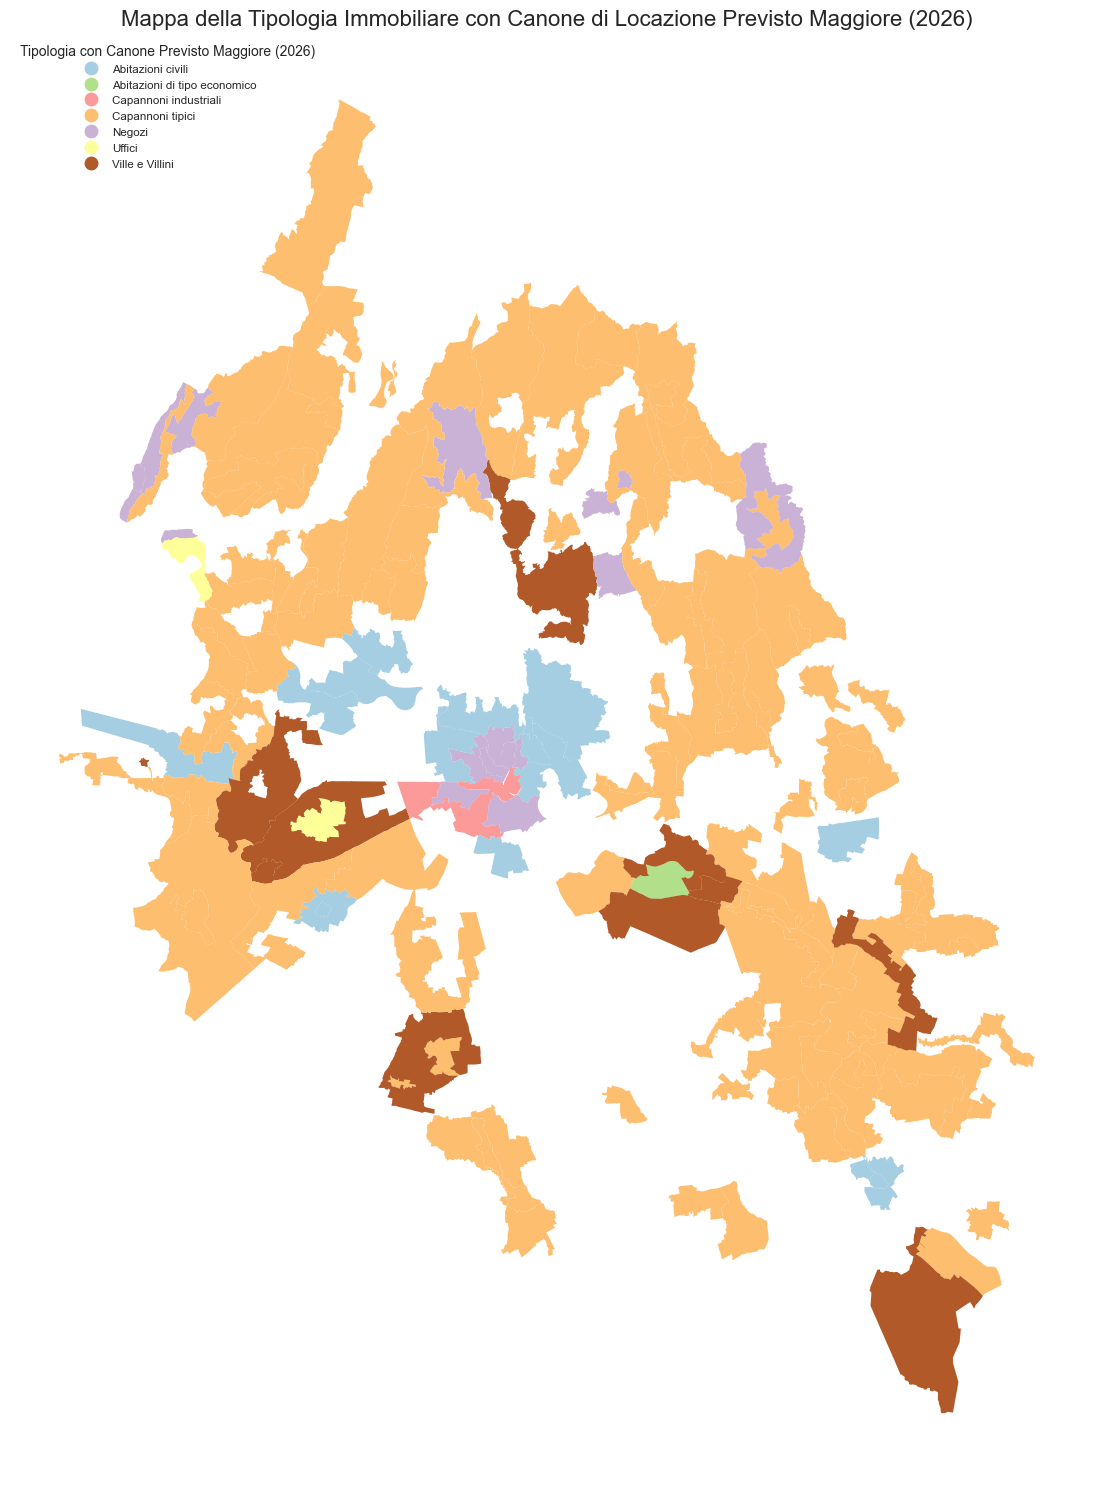

In [ ]:
# --- MAPPA DELLA TIPOLOGIA CON IL CANONE DI LOCAZIONE PREVISTO PIÙ ALTO (2026) ---
# Assicurati che 'gdf_completo_loc' sia disponibile dalla prima cella di questo output
if 'gdf_completo_loc' in locals() and not gdf_completo_loc.empty:

    # 1. PREPARA I DATI E IL PERIODO DI PREVISIONE
    periodo_futuro_2026 = 2026.0
    previsioni_locazione_per_tipologia = {}

    # 2. RAGGRUPPA, MODELLA E PREVEDI PER OGNI ZONA E TIPOLOGIA
    for zona, dati_zona in gdf_completo_loc.groupby('zona'):
        
        previsioni_in_zona = {}
        for tipologia, dati_tipologia in dati_zona.groupby('descr_tipologia'):
            
            if len(dati_tipologia) < 2:
                continue

            X = dati_tipologia[['periodo_num']]
            y = dati_tipologia['locazione_media_mq']

            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X, y)
            
            previsione = model.predict(np.array([[periodo_futuro_2026]]))
            previsioni_in_zona[tipologia] = previsione[0]
        
        if previsioni_in_zona:
            previsioni_locazione_per_tipologia[zona] = previsioni_in_zona

    # 3. IDENTIFICA LA TIPOLOGIA CON IL VALORE PREVISTO PIÙ ALTO PER ZONA
    tipologia_leader_locazione = {}
    for zona, previsioni in previsioni_locazione_per_tipologia.items():
        if previsioni:
            tipologia_leader = max(previsioni, key=previsioni.get)
            tipologia_leader_locazione[zona] = tipologia_leader

    # 4. CREA LA MAPPA CATEGORICA
    zone_geometrie = gdf_geospaziale.dissolve(by='zona')
    s_tipologia_leader_loc = pd.Series(tipologia_leader_locazione, name='tipologia_leader_locazione_2026')
    mappa_previsione_tipologia_loc = zone_geometrie.join(s_tipologia_leader_loc, how='inner')

    # Creazione della mappa
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    mappa_previsione_tipologia_loc.plot(
        column='tipologia_leader_locazione_2026',
        ax=ax,
        legend=True,
        categorical=True,
        cmap='Paired', # Usiamo un'altra colormap per distinguerla
        legend_kwds={'title': "Tipologia con Canone Previsto Maggiore (2026)", 'loc': 'upper left', 'fontsize':'small'},
        missing_kwds={"color": "lightgrey", "label": "Dati insufficienti"}
    )
    ax.set_title('Mappa della Tipologia Immobiliare con Canone di Locazione Previsto Maggiore (2026)', fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

else:
    print("DataFrame 'gdf_completo_loc' non disponibile. Esegui la prima cella di codice per crearlo.")

# MODELS

## Setup e Import

In [26]:
# Carica il tuo DataFrame
# Assumiamo che df_tabulare sia già stato caricato dalle celle precedenti del tuo notebook
# df = df_tabulare.copy() # Lavoriamo su una copia per sicurezza
df = df_tabulare

print("DataFrame caricato con successo.")
print(f"Shape iniziale: {df.shape}")

DataFrame caricato con successo.
Shape iniziale: (11681, 31)


## Feature Engineering e Pulizia Dati

In [27]:
# --- FEATURE ENGINEERING E PULIZIA ---

# 1. CREAZIONE DELLE VARIABILI TARGET
# Per la regressione (prezzo di compravendita)
df['prezzo_medio_mq'] = (df['compr_min'] + df['compr_max']) / 2

# Per la classificazione (tipologia di immobile)
# La nostra colonna target è 'descr_tipologia'
if 'target_class' not in df.columns:
    df = df.rename(columns={'descr_tipologia': 'target_class'})

# 2. CREAZIONE DELLE FEATURE
# Convertiamo il semestre in una feature numerica
def semestre_a_numero(s):
    try:
        anno, sem = s.split('_')
        return float(anno) + (0.5 if sem == '2' else 0.0)
    except:
        return np.nan

df['periodo_num'] = df['semestre'].apply(semestre_a_numero)

# 3. CONSOLIDAMENTO DELLE COLONNE DUPLICATE (CORRETTO)
# Usiamo i suffissi corretti '_val' e '_zone'
for col_name in ['fascia', 'comune_descrizione', 'stato_prev', 'comune_istat', 'comune_cat', 'comune_amm']:
    col_val = f'{col_name}_val'
    col_zone = f'{col_name}_zone'
    
    if col_val in df.columns and col_zone in df.columns:
        df[col_name] = df[col_val].fillna(df[col_zone])
        df.drop([col_val, col_zone], axis=1, inplace=True)
        print(f"Consolidata colonna: {col_name}")

# 4. PULIZIA FINALE
# Rimuoviamo le righe dove i nostri target principali sono nulli
df_reg = df.dropna(subset=['prezzo_medio_mq']).copy()
df_class = df.dropna(subset=['target_class']).copy()

print(f"\nShape per la regressione dopo pulizia: {df_reg.shape}")
print(f"Shape per la classificazione dopo pulizia: {df_class.shape}")

# DEBUG: Controlliamo che le colonne ora esistano
print("\nColonne nel DataFrame df_reg:")
print(df_reg.columns)

Consolidata colonna: fascia
Consolidata colonna: comune_descrizione
Consolidata colonna: stato_prev
Consolidata colonna: comune_istat
Consolidata colonna: comune_cat
Consolidata colonna: comune_amm

Shape per la regressione dopo pulizia: (11681, 26)
Shape per la classificazione dopo pulizia: (11681, 26)

Colonne nel DataFrame df_reg:
Index(['zona_val', 'linkzona', 'cod_tip', 'target_class', 'stato', 'compr_min',
       'compr_max', 'loc_min', 'loc_max', 'sup_nl_loc', 'semestre',
       'zona_descr', 'zona_zone', 'cod_tip_prev', 'descr_tip_prev',
       'microzona', 'prezzo_medio_mq', 'zona', 'locazione_media_mq',
       'periodo_num', 'fascia', 'comune_descrizione', 'stato_prev',
       'comune_istat', 'comune_cat', 'comune_amm'],
      dtype='object')


## Definizione delle Feature e Suddivisione dei Dati

In [28]:
# --- DEFINIZIONE FEATURE E SPLIT DEI DATI ---

# Definiamo le liste di colonne basandoci sulla loro tipologia
# Saranno usate dal preprocessor per applicare le trasformazioni corrette

# Feature numeriche
numerical_cols = [
    'periodo_num' # La nostra feature temporale
]

# Feature categoriche 
categorical_cols = [
    'fascia',              # Fascia dell'immobile
    'stato',               # Stato di conservazione
    'comune_descrizione',  # Nome del comune
    'descr_tip_prev',      # Tipologia prevalente nella zona
    'sup_nl_loc'           # Indicatore superficie per locazione
]

# Feature testuale 
text_col_name = 'zona_descr'

# Lista completa delle feature da usare
features = numerical_cols + categorical_cols + [text_col_name]

# --- PER IL MODELLO DI REGRESSIONE ---
X_reg = df_reg[features]
y_reg = df_reg['prezzo_medio_mq']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# --- PER IL MODELLO DI CLASSIFICAZIONE ---
X_class = df_class[features]
y_class = df_class['target_class']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.25, random_state=42)

print("Suddivisione dei dati in training e test completata.")

Suddivisione dei dati in training e test completata.


# Addestramento Modelli base

In [29]:
# --- ADDESTRAMENTO DI TUTTI I MODELLI DI REGRESSIONE BASE ---

print("="*60)
print("MODELLI DI REGRESSIONE BASE (Previsione Prezzo dal file models.py)")
print("="*60)

# Lista dei modelli di regressione da addestrare
modelli_reg = ['linear_regression', 'random_forest', 'lightgbm']

# Ciclo per addestrare e valutare ogni modello
for model_type in modelli_reg:
    train_regression_model(
        X_train=X_train_reg, 
        y_train=y_train_reg, 
        X_test=X_test_reg, 
        y_test=y_test_reg,
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols,
        text_col_name=text_col_name,
        model_type=model_type
    )


MODELLI DI REGRESSIONE BASE (Previsione Prezzo dal file models.py)

--- Linear Regression (Baseline) ---
Mean Squared Error (MSE): 133805.7752
R2 Score: 0.6479


KeyboardInterrupt: 


MODELLI DI CLASSIFICAZIONE BASE (Previsione Tipologia dal file models.py)

--- Logistic Regression Classifier (Baseline) ---
Accuracy: 0.3249
Classification Report:
                               precision    recall  f1-score   support

           Abitazioni civili       0.40      0.22      0.28       709
Abitazioni di tipo economico       0.21      0.59      0.31       276
                         Box       0.29      1.00      0.45        28
       Capannoni industriali       0.19      1.00      0.32         9
            Capannoni tipici       0.72      0.78      0.75       386
                  Laboratori       0.09      0.37      0.15        19
                   Magazzini       0.12      0.45      0.19        22
                      Negozi       0.23      0.19      0.21       431
                      Uffici       0.21      0.14      0.17       455
             Ville e Villini       0.36      0.22      0.27       586

                    accuracy                           0.32  

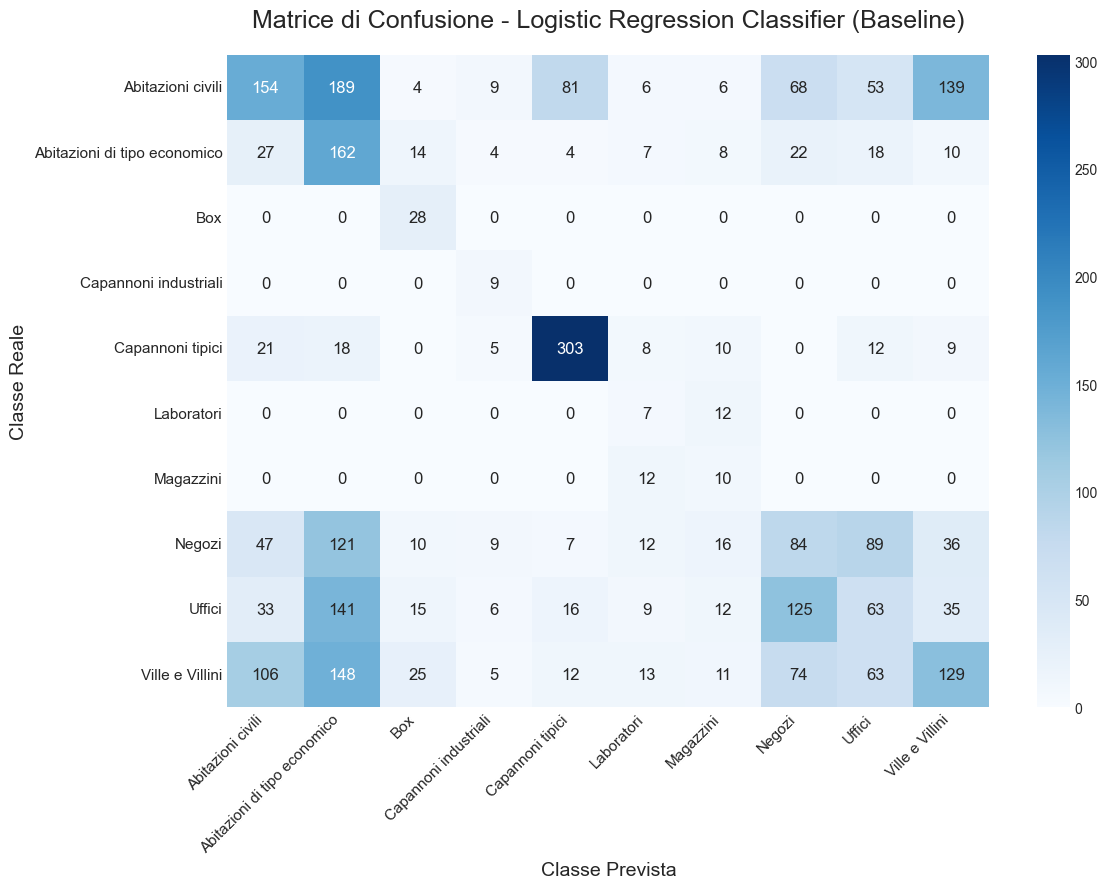


--- Random Forest Classifier ---
Accuracy: 0.2855
Classification Report:
                               precision    recall  f1-score   support

           Abitazioni civili       0.54      0.27      0.36       709
Abitazioni di tipo economico       0.16      0.49      0.24       276
                         Box       0.31      1.00      0.47        28
       Capannoni industriali       0.28      1.00      0.44         9
            Capannoni tipici       0.76      0.79      0.77       386
                  Laboratori       0.02      0.05      0.02        19
                   Magazzini       0.04      0.14      0.06        22
                      Negozi       0.12      0.11      0.11       431
                      Uffici       0.11      0.09      0.10       455
             Ville e Villini       0.27      0.13      0.17       586

                    accuracy                           0.29      2921
                   macro avg       0.26      0.41      0.28      2921
             

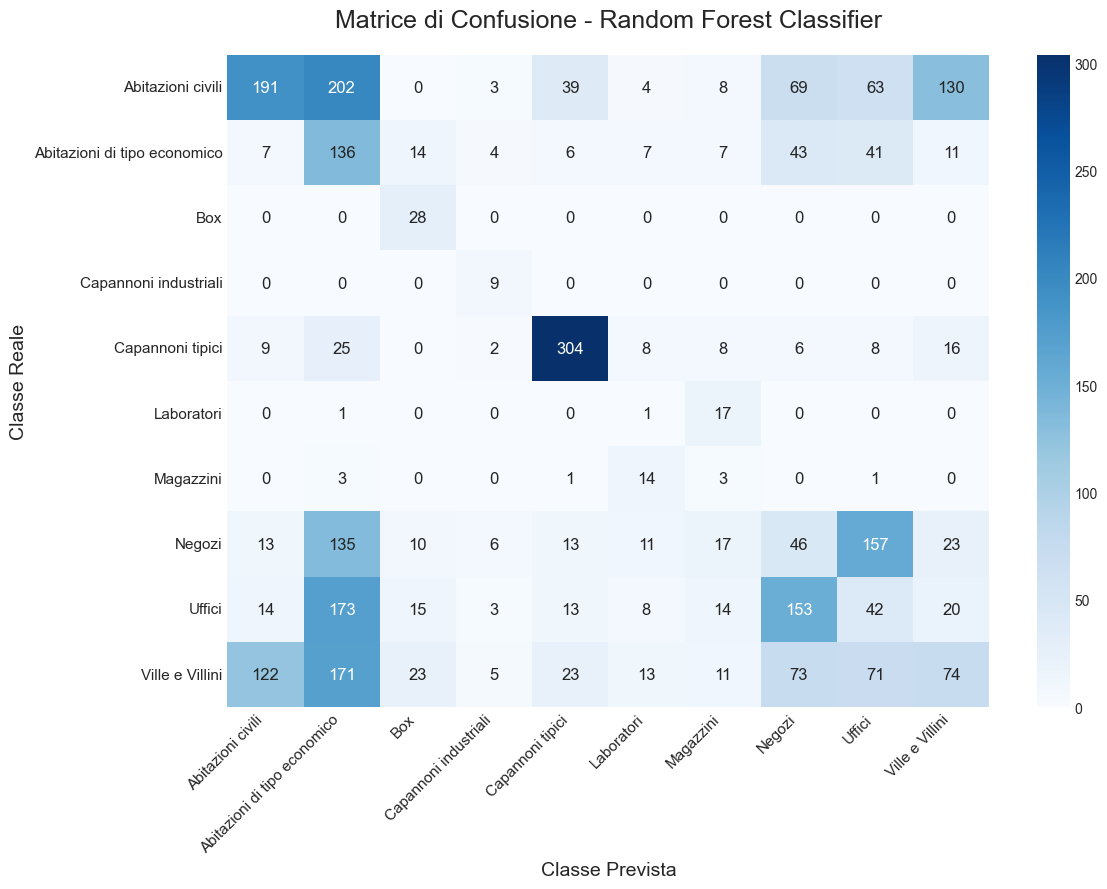

c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM Classifier ---
Accuracy: 0.2444
Classification Report:
                               precision    recall  f1-score   support

           Abitazioni civili       0.32      0.31      0.31       709
Abitazioni di tipo economico       0.04      0.05      0.05       276
                         Box       0.03      0.04      0.03        28
       Capannoni industriali       0.21      0.56      0.30         9
            Capannoni tipici       0.75      0.76      0.75       386
                  Laboratori       0.00      0.00      0.00        19
                   Magazzini       0.00      0.00      0.00        22
                      Negozi       0.11      0.10      0.11       431
                      Uffici       0.10      0.06      0.07       455
             Ville e Villini       0.16      0.18      0.17       586

                    accuracy                           0.24      2921
                   macro avg       0.17      0.21      0.18      2921
                we

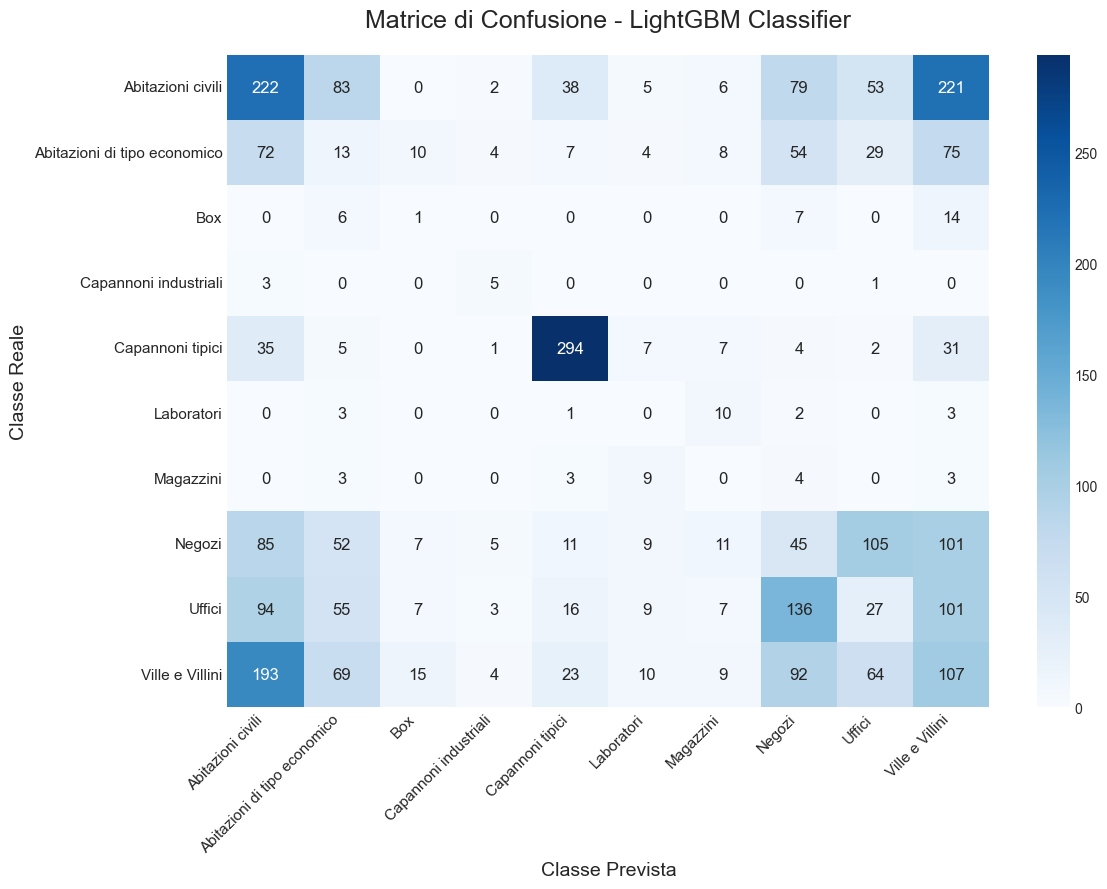

In [ ]:
# --- ADDESTRAMENTO DI TUTTI I MODELLI DI CLASSIFICAZIONE BASE ---

print("\n" + "="*60)
print("MODELLI DI CLASSIFICAZIONE BASE (Previsione Tipologia dal file models.py)")
print("="*60)

# Lista dei modelli di classificazione da addestrare
modelli_class = ['logistic_regression', 'random_forest', 'lightgbm']

# Ciclo per addestrare e valutare ogni modello
for model_type in modelli_class:
    train_classification_model(
        X_train=X_train_class, 
        y_train=y_train_class, 
        X_test=X_test_class, 
        y_test=y_test_class,
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols,
        text_col_name=text_col_name,
        model_type=model_type
    )


## Rete neurale base

In [ ]:
# --- ADDESTRAMENTO MODELLI PYTORCH BASE (da pytorch_models.py) ---
# Impostazioni generali
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizzato per PyTorch: {device}")


# ===================================================================
# 1. MODELLO DI REGRESSIONE (Previsione Prezzo)
# ===================================================================
print("\n" + "="*60)
print("RETE NEURALE DI REGRESSIONE (pytorch_models.py)")
print("="*60)

# 1.1 Preprocessing dei dati di regressione
preprocessor_reg = create_preprocessor(numerical_cols, categorical_cols, text_col_name)
X_train_reg_torch = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_torch = preprocessor_reg.transform(X_test_reg)
input_size_reg = X_train_reg_torch.shape[1]

# 1.2 Creazione Dataset e DataLoader
train_dataset_reg = TabularDataset(X_train_reg_torch, y_train_reg.values)
test_dataset_reg = TabularDataset(X_test_reg_torch, y_test_reg.values)
train_loader_reg = DataLoader(dataset=train_dataset_reg, batch_size=64, shuffle=True)
test_loader_reg = DataLoader(dataset=test_dataset_reg, batch_size=64, shuffle=False)

# 1.3 Inizializzazione e addestramento
model_reg_nn = RegressionNN(input_size=input_size_reg).to(device)
loss_fn_reg = nn.MSELoss()
optimizer_reg = torch.optim.Adam(model_reg_nn.parameters(), lr=0.001)

print("\n--- Inizio Addestramento Rete Neurale di Regressione ---")
for epoch in range(50): # Ridotto a 50 epoche per un'esecuzione più rapida
    loss = train_model(model_reg_nn, train_loader_reg, loss_fn_reg, optimizer_reg, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoca {epoch+1}/50, Loss: {loss:.4f}")

# 1.4 Valutazione
print("\n--- Valutazione Rete Neurale di Regressione ---")
mse_nn, r2_nn = evaluate_regression(model_reg_nn, test_loader_reg, device)
print(f"Mean Squared Error (MSE) sul test set: {mse_nn:.4f}")
print(f"R2 Score sul test set: {r2_nn:.4f}")

Dispositivo utilizzato per PyTorch: cpu

RETE NEURALE DI REGRESSIONE (pytorch_models.py)

--- Inizio Addestramento Rete Neurale di Regressione ---
Epoca 10/50, Loss: 161715.5672
Epoca 20/50, Loss: 147363.4038
Epoca 30/50, Loss: 130969.5751
Epoca 40/50, Loss: 121958.1580
Epoca 50/50, Loss: 115876.2189

--- Valutazione Rete Neurale di Regressione ---
Mean Squared Error (MSE) sul test set: 96775.5625
R2 Score sul test set: 0.7453


In [ ]:
# =======================================================================
# 2. MODELLO DI CLASSIFICAZIONE (Previsione Tipologia)
# =======================================================================
print("\n" + "="*60)
print("RETE NEURALE DI CLASSIFICAZIONE (pytorch_models.py)")
print("="*60)

# 2.1 Preprocessing dei dati di classificazione
preprocessor_class = create_preprocessor(numerical_cols, categorical_cols, text_col_name)
X_train_class_torch = preprocessor_class.fit_transform(X_train_class)
X_test_class_torch = preprocessor_class.transform(X_test_class)
input_size_class = X_train_class_torch.shape[1]

# 2.2 Encoding delle etichette (da stringa a numero)
label_encoder = LabelEncoder()
y_train_class_enc = label_encoder.fit_transform(y_train_class)
y_test_class_enc = label_encoder.transform(y_test_class)
class_names = label_encoder.classes_
num_classes = len(class_names)
print(f"Trovate {num_classes} classi: {class_names.tolist()}")

# 2.3 Creazione Dataset e DataLoader
train_dataset_class = TabularDataset(X_train_class_torch, y_train_class_enc, is_classification=True)
test_dataset_class = TabularDataset(X_test_class_torch, y_test_class_enc, is_classification=True)
train_loader_class = DataLoader(dataset=train_dataset_class, batch_size=64, shuffle=True)
test_loader_class = DataLoader(dataset=test_dataset_class, batch_size=64, shuffle=False)

# 2.4 Inizializzazione e addestramento
model_class_nn = ClassificationNN(input_size=input_size_class, num_classes=num_classes).to(device)
loss_fn_class = nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(model_class_nn.parameters(), lr=0.001)

print("\n--- Inizio Addestramento Rete Neurale di Classificazione ---")
for epoch in range(50):
    loss = train_model(model_class_nn, train_loader_class, loss_fn_class, optimizer_class, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoca {epoch+1}/50, Loss: {loss:.4f}")

# 2.5 Valutazione (la funzione aggiornata stamperà anche la matrice di confusione)
print("\n--- Valutazione Rete Neurale di Classificazione ---")

# --- CORREZIONE QUI ---
# Passiamo la lista completa delle classi, non un suo sottoinsieme.
evaluate_classification(
    model=model_class_nn, 
    data_loader=test_loader_class, 
    device=device,
    class_names=label_encoder.classes_, # <-- MODIFICA CHIAVE
    model_name="Rete Neurale di Classificazione Base"
)



RETE NEURALE DI CLASSIFICAZIONE (pytorch_models.py)
Trovate 10 classi: ['Abitazioni civili', 'Abitazioni di tipo economico', 'Box', 'Capannoni industriali', 'Capannoni tipici', 'Laboratori', 'Magazzini', 'Negozi', 'Uffici', 'Ville e Villini']

--- Inizio Addestramento Rete Neurale di Classificazione ---
Epoca 10/50, Loss: 1.2324
Epoca 20/50, Loss: 1.1702
Epoca 30/50, Loss: 1.1409
Epoca 40/50, Loss: 1.1271
Epoca 50/50, Loss: 1.1155

--- Valutazione Rete Neurale di Classificazione ---


ValueError: At least one label specified must be in y_true

## Tuning di tutti i modelli 

In [ ]:
# --- TUNING DI TUTTI I MODELLI CLASSICI CON GRIDSEARCHCV ---
# ===================================================================
# 1. TUNING PER LA REGRESSIONE (Ridge, Random Forest, LightGBM)
# ===================================================================

# Definiamo le griglie di parametri per ogni modello di regressione
param_grids_reg = {
    'ridge': {
        'alpha': [0.1, 1.0, 10.0, 50.0, 100.0] # 'alpha' è il parametro di regolarizzazione per Ridge
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [2, 4]
    },
    'lightgbm': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 40, 50]
    }
}

# Ciclo per avviare il tuning di ogni modello di regressione
for model_type, param_grid in param_grids_reg.items():
    print("\n" + "="*60)
    print(f"TUNING MODELLO DI REGRESSIONE: {model_type.upper()}")
    print("="*60)
    
    train_tuned_regression_model(
        X_train=X_train_reg, 
        y_train=y_train_reg,
        X_test=X_test_reg,
        y_test=y_test_reg,
        numerical_cols=numerical_cols, 
        categorical_cols=categorical_cols, 
        text_col_name=text_col_name,
        model_type=model_type,
        param_grid=param_grid,
        cv=3, 
        scoring='r2'
    )


In [ ]:
# =======================================================================
# 2. TUNING PER LA CLASSIFICAZIONE (Logistic, Random Forest, LightGBM)
# =======================================================================

# Definiamo le griglie di parametri per ogni modello di classificazione
param_grids_class = {
    'logistic_regression': {
        'C': [0.1, 1.0, 10.0], # 'C' è l'inverso della forza di regolarizzazione
        'penalty': ['l1', 'l2']
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'class_weight': ['balanced', None]
    },
    'lightgbm': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 40],
        'class_weight': ['balanced', None]
    }
}

# Ciclo per avviare il tuning di ogni modello di classificazione
for model_type, param_grid in param_grids_class.items():
    print("\n" + "="*60)
    print(f"TUNING MODELLO DI CLASSIFICAZIONE: {model_type.upper()}")
    print("="*60)
    
    train_tuned_classification_model(
        X_train=X_train_class, 
        y_train=y_train_class,
        X_test=X_test_class,
        y_test=y_test_class,
        numerical_cols=numerical_cols, 
        categorical_cols=categorical_cols, 
        text_col_name=text_col_name,
        model_type=model_type,
        param_grid=param_grid,
        cv=3,
        scoring='f1_weighted'
    )

## Tuning rete neurale

In [ ]:
# --- POTENZIAMENTO E TUNING DELLA RETE NEURALE (v2) ---

# Riusiamo i dati già preprocessati e splittati dalle celle precedenti
# (X_train_reg_torch, X_test_reg_torch, ecc.)

# --- REGRESSIONE: TUNING MANUALE ---
print("\n" + "="*50)
print("TUNING RETE NEURALE DI REGRESSIONE (v2)")
print("="*50)

# Iperparametri da testare
learning_rates = [0.001, 0.0005]
dropout_rates = [0.3, 0.5]
best_r2_reg = -1
best_params_reg_nn = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"\nTraining con LR={lr}, Dropout={dr}")
        
        # Inizializzazione
        model_reg_v2 = RegressionNN_v2(input_size=input_size_reg, dropout_rate=dr).to(device)
        loss_fn_reg = nn.MSELoss()
        optimizer_reg = torch.optim.Adam(model_reg_v2.parameters(), lr=lr)

        # Addestramento con più epoche
        for epoch in range(100):  # Aumentato a 100 epoche per un training più robusto
            print(f"Epoca {epoch+1}/100")
            train_model(model_reg_v2, train_loader_reg, loss_fn_reg, optimizer_reg, device)

        # Valutazione
        mse, r2 = evaluate_regression(model_reg_v2, test_loader_reg, device)
        print(f"Risultato: R2={r2:.4f}, MSE={mse:.4f}")

        if r2 > best_r2_reg:
            best_r2_reg = r2
            best_params_reg_nn = {'learning_rate': lr, 'dropout_rate': dr}

print("\n--- Risultati Tuning Regressione NN ---")
print(f"Miglior R2 Score: {best_r2_reg:.4f}")
print(f"Migliori Iperparametri: {best_params_reg_nn}")


TUNING RETE NEURALE DI REGRESSIONE (v2)

Training con LR=0.001, Dropout=0.3
Epoca 1/100
Epoca 2/100
Epoca 3/100
Epoca 4/100
Epoca 5/100
Epoca 6/100
Epoca 7/100
Epoca 8/100
Epoca 9/100
Epoca 10/100
Epoca 11/100
Epoca 12/100
Epoca 13/100
Epoca 14/100
Epoca 15/100
Epoca 16/100
Epoca 17/100
Epoca 18/100
Epoca 19/100
Epoca 20/100
Epoca 21/100
Epoca 22/100
Epoca 23/100
Epoca 24/100
Epoca 25/100
Epoca 26/100
Epoca 27/100
Epoca 28/100
Epoca 29/100
Epoca 30/100
Epoca 31/100
Epoca 32/100
Epoca 33/100
Epoca 34/100
Epoca 35/100
Epoca 36/100
Epoca 37/100
Epoca 38/100
Epoca 39/100
Epoca 40/100
Epoca 41/100
Epoca 42/100
Epoca 43/100
Epoca 44/100
Epoca 45/100
Epoca 46/100
Epoca 47/100
Epoca 48/100
Epoca 49/100
Epoca 50/100
Epoca 51/100
Epoca 52/100
Epoca 53/100
Epoca 54/100
Epoca 55/100
Epoca 56/100
Epoca 57/100


KeyboardInterrupt: 

In [ ]:
# --- CLASSIFICAZIONE: TUNING MANUALE ---
print("\n" + "="*50)
print("TUNING RETE NEURALE DI CLASSIFICAZIONE (v2)")
print("="*50)

best_acc_class = -1
best_params_class_nn = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"\nTraining con LR={lr}, Dropout={dr}")
        
        # Inizializzazione
        model_class_v2 = ClassificationNN_v2(input_size=input_size_class, num_classes=num_classes, dropout_rate=dr).to(device)
        loss_fn_class = nn.CrossEntropyLoss()
        optimizer_class = torch.optim.Adam(model_class_v2.parameters(), lr=lr)

        # Addestramento
        for epoch in range(100):
            print(f"Epoca {epoch+1}/100")
            # Aumentiamo le epoche per un training più robusto
            train_model(model_class_v2, train_loader_class, loss_fn_class, optimizer_class, device)

        # Valutazione
        acc, _ = evaluate_classification(model_class_v2, test_loader_class, device)
        print(f"Risultato: Accuracy={acc:.4f}")

        if acc > best_acc_class:
            best_acc_class = acc
            best_params_class_nn = {'learning_rate': lr, 'dropout_rate': dr}

print("\n--- Risultati Tuning Classificazione NN ---")
print(f"Miglior Accuracy: {best_acc_class:.4f}")
print(f"Migliori Iperparametri: {best_params_class_nn}")

### Data pre-processing per classificazione - miglioramento risultati

In [ ]:
# --- PREPARAZIONE DATI SPECIFICA PER IL MODELLO DI CLASSIFICAZIONE ---

print("Preparo i dati per la classificazione...")

# 1. PREPROCESSING DELLE FEATURE (usa i dati splittati per la classificazione)
preprocessor_class = create_preprocessor(numerical_cols, categorical_cols, text_col_name)
X_train_class_torch = preprocessor_class.fit_transform(X_train_class)
X_test_class_torch = preprocessor_class.transform(X_test_class)
input_size_class = X_train_class_torch.shape[1] # <-- Definizione di input_size_class

# 2. LABEL ENCODING DEL TARGET
# Le reti neurali richiedono target numerici, quindi convertiamo le stringhe (es. 'Abitazioni') in numeri (0, 1, 2...)
label_encoder = LabelEncoder()
y_train_class_enc = label_encoder.fit_transform(y_train_class)
y_test_class_enc = label_encoder.transform(y_test_class)
num_classes = len(label_encoder.classes_)

# 3. CREAZIONE DEI DATALOADER
BATCH_SIZE = 64
train_dataset_class = TabularDataset(X_train_class_torch, y_train_class_enc, is_classification=True)
test_dataset_class = TabularDataset(X_test_class_torch, y_test_class_enc, is_classification=True)

# <-- Definizione di train_loader_class e test_loader_class
train_loader_class = DataLoader(dataset=train_dataset_class, batch_size=BATCH_SIZE, shuffle=True)
test_loader_class = DataLoader(dataset=test_dataset_class, batch_size=BATCH_SIZE, shuffle=False)

print("\nDati per la classificazione pronti.")
print(f"Input size: {input_size_class}, Numero di classi: {num_classes}")

Preparo i dati per la classificazione...

Dati per la classificazione pronti.
Input size: 215, Numero di classi: 10


A causa della disparità presente tra le classi ne sono state aggregate alcune...

In [ ]:
print(df_class.columns)

Index(['zona_val', 'linkzona', 'cod_tip', 'target_class', 'stato', 'compr_min',
       'compr_max', 'loc_min', 'loc_max', 'sup_nl_loc', 'semestre',
       'zona_descr', 'zona_zone', 'cod_tip_prev', 'descr_tip_prev',
       'microzona', 'prezzo_medio_mq', 'zona', 'locazione_media_mq',
       'periodo_num', 'fascia', 'comune_descrizione', 'stato_prev',
       'comune_istat', 'comune_cat', 'comune_amm'],
      dtype='object')


In [ ]:
print(y_class.value_counts())

target_class
Abitazioni civili               2815
Ville e Villini                 2474
Uffici                          1713
Negozi                          1711
Capannoni tipici                1544
Abitazioni di tipo economico    1122
Box                              110
Magazzini                         81
Laboratori                        71
Capannoni industriali             40
Name: count, dtype: int64


In [ ]:
# --- AGGREGAZIONE PERSONALIZZATA E RI-ADDESTRAMENTO DI TUTTI I MODELLI BASE ---
# 1. DEFINIZIONE DELLA NUOVA MAPPATURA PERSONALIZZATA
mapping_tipologie_personalizzato = {
    'Abitazioni civili': 'Abitazioni civili',
    'Ville e Villini': 'Ville e Villini',
    'Uffici': 'Uffici/Negozi/Economico',
    'Negozi': 'Uffici/Negozi/Economico',
    'Abitazioni di tipo economico': 'Uffici/Negozi/Economico',
    'Capannoni tipici': 'Industriale',
    'Capannoni industriali': 'Industriale',
    'Box': 'Box/Magazzini/Laboratori',
    'Magazzini': 'Box/Magazzini/Laboratori',
    'Laboratori': 'Box/Magazzini/Laboratori'
}

# 2. APPLICAZIONE DELLA MAPPATURA
# Usiamo il DataFrame 'df_class' creato in precedenza
df_class_pers = df_class.copy()
df_class_pers['target_class_agg'] = df_class_pers['target_class'].map(mapping_tipologie_personalizzato)
df_class_pers.dropna(subset=['target_class_agg'], inplace=True)

print("Distribuzione delle nuove 5 tipologie aggregate:")
print(df_class_pers['target_class_agg'].value_counts())
print("-" * 50)

# 3. SUDDIVISIONE DEI DATI CON IL NUOVO TARGET
features = numerical_cols + categorical_cols + [text_col_name]
X_class_pers = df_class_pers[features]
y_class_pers = df_class_pers['target_class_agg']

X_train_pers, X_test_pers, y_train_pers, y_test_pers = train_test_split(
    X_class_pers, y_class_pers, 
    test_size=0.25, 
    random_state=42,
    stratify=y_class_pers
)


Distribuzione delle nuove 5 tipologie aggregate:
target_class_agg
Uffici/Negozi/Economico     4546
Abitazioni civili           2815
Ville e Villini             2474
Industriale                 1584
Box/Magazzini/Laboratori     262
Name: count, dtype: int64

Suddivisione dati con la nuova aggregazione completata.

MODELLO LIGHTGBM (CON 5 CLASSI AGGREGATE)


c:\Users\emmal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM Classifier ---
Accuracy: 0.5522
Classification Report:
                           precision    recall  f1-score   support

       Abitazioni civili       0.46      0.26      0.34       704
Box/Magazzini/Laboratori       0.09      0.06      0.07        65
             Industriale       0.81      0.77      0.79       396
 Uffici/Negozi/Economico       0.56      0.91      0.69      1137
         Ville e Villini       0.34      0.14      0.20       619

                accuracy                           0.55      2921
               macro avg       0.45      0.43      0.42      2921
            weighted avg       0.51      0.55      0.50      2921


RETE NEURALE (CON 5 CLASSI AGGREGATE)
Numero di nuove classi: 5

--- Inizio Addestramento Rete Neurale (5 Classi Aggregate) ---
Epoca 5/35, Loss: 0.8563
Epoca 10/35, Loss: 0.8111
Epoca 15/35, Loss: 0.7970
Epoca 20/35, Loss: 0.7872
Epoca 25/35, Loss: 0.7828
Epoca 30/35, Loss: 0.7803
Epoca 35/35, Loss: 0.7732

--- Valutazione Rete N

In [ ]:
# 4. RI-ADDESTRAMENTO DI TUTTI I MODELLI DI CLASSIFICAZIONE BASE
print("\n" + "="*60)
print("RI-ADDESTRAMENTO MODELLI BASE (CON 5 CLASSI AGGREGATE)")
print("="*60)

# Lista dei modelli di classificazione da addestrare
modelli_class_base = ['logistic_regression', 'random_forest', 'lightgbm']

# Ciclo per addestrare e valutare ogni modello sui nuovi dati aggregati
for model_type in modelli_class_base:
    train_classification_model(
        X_train=X_train_pers, 
        y_train=y_train_pers, 
        X_test=X_test_pers, 
        y_test=y_test_pers,
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols,
        text_col_name=text_col_name,
        model_type=model_type
    )

In [ ]:
# --- RI-ADDESTRAMENTO RETE NEURALE BASE (CON 5 CLASSI AGGREGATE) ---

print("\n" + "="*60)
print("RI-ADDESTRAMENTO RETE NEURALE BASE (CON 5 CLASSI AGGREGATE)")
print("="*60)

# 1. Preprocessing (invariato)
preprocessor_pers = create_preprocessor(numerical_cols, categorical_cols, text_col_name)
X_train_pers_torch = preprocessor_pers.fit_transform(X_train_pers)
X_test_pers_torch = preprocessor_pers.transform(X_test_pers)
input_size_pers = X_train_pers_torch.shape[1]

# 2. Label Encoding (invariato)
label_encoder_pers = LabelEncoder()
y_train_pers_enc = label_encoder_pers.fit_transform(y_train_pers)
y_test_pers_enc = label_encoder_pers.transform(y_test_pers)
class_names_pers = label_encoder_pers.classes_
num_classes_pers = len(class_names_pers)
print(f"Numero di nuove classi: {num_classes_pers} - {class_names_pers.tolist()}")

# 3. DataLoaders (invariato)
train_dataset_pers = TabularDataset(X_train_pers_torch, y_train_pers_enc, is_classification=True)
test_dataset_pers = TabularDataset(X_test_pers_torch, y_test_pers_enc, is_classification=True)
train_loader_pers = DataLoader(dataset=train_dataset_pers, batch_size=64, shuffle=True)
test_loader_pers = DataLoader(dataset=test_dataset_pers, batch_size=64, shuffle=False)

# 4. Inizializzazione e addestramento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CORREZIONE QUI: Usiamo ClassificationNN (il modello base) ---
model_class_pers_nn = ClassificationNN(input_size=input_size_pers, num_classes=num_classes_pers).to(device)
# ----------------------------------------------------------------

loss_fn_pers = nn.CrossEntropyLoss()
optimizer_pers = torch.optim.Adam(model_class_pers_nn.parameters(), lr=0.001) # Usiamo un learning rate standard

print("\n--- Inizio Addestramento Rete Neurale Base (5 Classi Aggregate) ---")
for epoch in range(50): # 50 epoche sono un buon punto di partenza
    loss = train_model(model_class_pers_nn, train_loader_pers, loss_fn_pers, optimizer_pers, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoca {epoch+1}/50, Loss: {loss:.4f}")

# 5. Valutazione 
# --- CORREZIONE QUI: La funzione evaluate_classification fa già tutto ---
print("\n--- Valutazione Rete Neurale Base (5 Classi Aggregate) ---")
evaluate_classification(
    model=model_class_pers_nn, 
    data_loader=test_loader_pers, 
    device=device,
    class_names=class_names_pers,
    model_name="Rete Neurale Base (5 Classi)"
)



RETE NEURALE (CON 5 CLASSI AGGREGATE)
Numero di nuove classi: 5

--- Inizio Addestramento Rete Neurale (5 Classi Aggregate) ---
Epoca 5/55, Loss: 0.8512
Epoca 10/55, Loss: 0.8095
Epoca 15/55, Loss: 0.7944
Epoca 20/55, Loss: 0.7870
Epoca 25/55, Loss: 0.7804
Epoca 30/55, Loss: 0.7780
Epoca 35/55, Loss: 0.7791
Epoca 40/55, Loss: 0.7737
Epoca 45/55, Loss: 0.7755
Epoca 50/55, Loss: 0.7704
Epoca 55/55, Loss: 0.7692

--- Valutazione Rete Neurale (5 Classi Aggregate) ---
Accuracy sul test set (5 Classi Aggregate): 0.6001

Classification Report (Rete Neurale - 5 Classi):
                           precision    recall  f1-score   support

       Abitazioni civili       0.83      0.18      0.30       704
Box/Magazzini/Laboratori       0.67      0.03      0.06        65
             Industriale       0.89      0.78      0.83       396
 Uffici/Negozi/Economico       0.55      0.97      0.70      1137
         Ville e Villini       0.51      0.34      0.41       619

                accuracy       

## Riaddestramento modelli tuned 

In [ ]:
# --- RI-ADDESTRAMENTO MODELLI TUNED E PYTORCH ENHANCED SULLE CLASSI AGGREGATE ---
# =======================================================================
# 2. RI-ADDESTRAMENTO E TUNING DEI MODELLI SCIKIT-LEARN
# =======================================================================

# 2.1 Definizione delle griglie di parametri
param_grids_class = {
    'logistic_regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2']
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'class_weight': ['balanced', None]
    },
    'lightgbm': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 40],
        'class_weight': ['balanced', None]
    }
}

# 2.2 Ciclo per avviare il tuning di ogni modello
for model_type, param_grid in param_grids_class.items():
    print("\n" + "="*60)
    print(f"TUNING MODELLO {model_type.upper()} (CON 5 CLASSI AGGREGATE)")
    print("="*60)
    
    train_tuned_classification_model(
        X_train=X_train_pers, 
        y_train=y_train_pers,
        X_test=X_test_pers,
        y_test=y_test_pers,
        numerical_cols=numerical_cols, 
        categorical_cols=categorical_cols, 
        text_col_name=text_col_name,
        model_type=model_type,
        param_grid=param_grid,
        cv=3,
        scoring='f1_weighted'
    )

### Riaddestramento rete neurale tuned

In [ ]:
# =======================================================================
# 3. RI-ADDESTRAMENTO DELLA RETE NEURALE POTENZIATA (PYTORCH)
# =======================================================================
print("\n" + "="*60)
print("RI-ADDESTRAMENTO RETE NEURALE POTENZIATA (CON 5 CLASSI AGGREGATE)")
print("="*60)

# 3.1 Preprocessing dei dati
preprocessor_torch = create_preprocessor(numerical_cols, categorical_cols, text_col_name)
X_train_torch_pers = preprocessor_torch.fit_transform(X_train_pers)
X_test_torch_pers = preprocessor_torch.transform(X_test_pers)
input_size = X_train_torch_pers.shape[1]

# 3.2 Encoding delle etichette
label_encoder_pers = LabelEncoder()
y_train_enc_pers = label_encoder_pers.fit_transform(y_train_pers)
y_test_enc_pers = label_encoder_pers.transform(y_test_pers)
class_names_pers = label_encoder_pers.classes_
num_classes_pers = len(class_names_pers)
print(f"Nuove classi per PyTorch: {class_names_pers}")

# 3.3 Creazione Dataset e DataLoader
train_dataset_pers = TabularDataset(X_train_torch_pers, y_train_enc_pers, is_classification=True)
test_dataset_pers = TabularDataset(X_test_torch_pers, y_test_enc_pers, is_classification=True)
train_loader_pers = DataLoader(dataset=train_dataset_pers, batch_size=64, shuffle=True)
test_loader_pers = DataLoader(dataset=test_dataset_pers, batch_size=64, shuffle=False)

# 3.4 Inizializzazione e addestramento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_nn_pers = ClassificationNN_v2(input_size=input_size, num_classes=num_classes_pers).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nn_pers.parameters(), lr=0.001)

print("\n--- Inizio Addestramento Rete Neurale Potenziata ---")
for epoch in range(50):
    loss = train_model(model_nn_pers, train_loader_pers, loss_fn, optimizer, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoca {epoch+1}/50, Loss: {loss:.4f}")

# 3.5 Valutazione
print("\n--- Valutazione Rete Neurale Potenziata ---")
evaluate_classification(
    model_nn_pers, 
    test_loader_pers, 
    device,
    class_names=class_names_pers,
    model_name="Rete Neurale Potenziata (5 Classi)"
)

## Geospatial Feature Engineering

In [ ]:
print("--- Inizio Geospatial Feature Engineering ---")

# Assumiamo che 'gdf_geospaziale' sia il tuo GeoDataFrame con le geometrie
# e 'df_tabulare' quello con i dati OMI, come nelle celle precedenti.

# 1. Aggreghiamo le geometrie per avere una geometria unica per ogni zona OMI
if 'geometry' in gdf_geospaziale.columns:
    zone_geometrie = gdf_geospaziale.dissolve(by='zona')

    # 2. CALCOLO DELLE FEATURE GEOGRAFICHE
    # Assicuriamoci che il CRS sia proiettato
    # per calcolare area e distanza in metri/km (qui usiamo EPSG:32632 per l'Italia del nord)
    zone_geometrie_proj = zone_geometrie.to_crs("epsg:32632")

    zone_geometrie['area_km2'] = zone_geometrie_proj.geometry.area / 1_000_000
    
    # --- CORREZIONE QUI ---
    zone_geometrie['perimetro_km'] = zone_geospaziale.geometry.length / 1_000 # CORREZIONE: .length invece di .perimeter
    
    # Calcolo della compattezza (Polsby-Popper test)
    zone_geometrie['compattezza'] = (4 * np.pi * zone_geometrie['area_km2']) / (zone_geometrie['perimetro_km']**2)

    # Calcolo delle coordinate del centroide (in gradi decimali, CRS originale WGS84)
    zone_geometrie['centroid_lon'] = zone_geometrie.geometry.centroid.x
    zone_geometrie['centroid_lat'] = zone_geometrie.geometry.centroid.y
    
    # 3. CALCOLO DELLA DISTANZA DAL CENTRO DI VERONA
    # Coordinate approssimative dell'Arena di Verona
    centro_verona = Point(10.9940, 45.4388)
    
    centro_verona_gdf = gpd.GeoSeries([centro_verona], crs="epsg:4326").to_crs("epsg:32632")

    zone_geometrie['distanza_centro_km'] = zone_geometrie_proj.geometry.centroid.distance(centro_verona_gdf.iloc[0]) / 1_000

    print("Feature geospaziali create con successo:")
    print(zone_geometrie[['area_km2', 'perimetro_km', 'compattezza', 'centroid_lon', 'centroid_lat', 'distanza_centro_km']].head())

    # 4. UNIONE DELLE NUOVE FEATURE AL DATAFRAME PRINCIPALE
    zone_features = zone_geometrie.reset_index()
    
    if 'zona' not in df_tabulare.columns:
        df_tabulare['zona'] = df_tabulare['comune_descrizione_val'] + ' - Zona OMI ' + df_tabulare['zona_val']

    df_geospatial = pd.merge(df_tabulare, zone_features[['zona', 'area_km2', 'perimetro_km', 'compattezza', 'centroid_lon', 'centroid_lat', 'distanza_centro_km']], on='zona', how='left')

    print(f"\nDataFrame arricchito creato. Nuova shape: {df_geospatial.shape}")
else:
    print("Errore: 'gdf_geospaziale' non trovato.")

--- Inizio Geospatial Feature Engineering ---


C:\Users\emmal\AppData\Local\Temp\ipykernel_14020\2308679449.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_geometrie['centroid_lon'] = zone_geometrie.geometry.centroid.x
C:\Users\emmal\AppData\Local\Temp\ipykernel_14020\2308679449.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_geometrie['centroid_lat'] = zone_geometrie.geometry.centroid.y


Feature geospaziali create con successo:
                                  area_km2  perimetro_km  compattezza  \
zona                                                                    
AFFI - Zona OMI B1                5.117342     14.966888     0.287072   
AFFI - Zona OMI R1                2.850101      9.149254     0.427857   
AFFI - Zona OMI R2                1.943728      7.751300     0.406534   
ALBAREDO D39;ADIGE - Zona OMI B1  4.814553     10.895651     0.509635   
ALBAREDO D39;ADIGE - Zona OMI E1  3.977529     16.122669     0.192287   

                                  centroid_lon  centroid_lat  \
zona                                                           
AFFI - Zona OMI B1                   10.781499     45.552921   
AFFI - Zona OMI R1                   10.780825     45.566895   
AFFI - Zona OMI R2                   10.757722     45.552295   
ALBAREDO D39;ADIGE - Zona OMI B1     11.276666     45.318051   
ALBAREDO D39;ADIGE - Zona OMI E1     11.306314     45.282728   

#### Ri-addestramento dei Modelli con le Nuove Feature

In [ ]:


# Il DataFrame di partenza è 'df_geospatial' creato nella cella precedente.
df = df_geospatial.copy()

# 1. FEATURE ENGINEERING E CONSOLIDAMENTO COLONNE
# Questo blocco deve essere eseguito PRIMA di definire le liste di feature.
print("Eseguo Feature Engineering e consolidamento colonne...")

# Creazione target e feature numeriche/categoriche
df['prezzo_medio_mq'] = (df['compr_min'] + df['compr_max']) / 2
if 'target_class' not in df.columns:
    df = df.rename(columns={'descr_tipologia': 'target_class'})

def semestre_a_numero(s):
    try:
        anno, sem = s.split('_')
        return float(anno) + (0.5 if sem == '2' else 0.0)
    except:
        return np.nan
df['periodo_num'] = df['semestre'].apply(semestre_a_numero)

# Consolidamento delle colonne _val e _zone
for col_name in ['fascia', 'comune_descrizione', 'stato_prev', 'comune_istat', 'comune_cat', 'comune_amm']:
    col_val = f'{col_name}_val'
    col_zone = f'{col_name}_zone'
    if col_val in df.columns and col_zone in df.columns:
        df[col_name] = df[col_val].fillna(df[col_zone])
        df.drop([col_val, col_zone], axis=1, inplace=True)

# Aggregazione delle classi
mapping_tipologie_personalizzato =  {
    'Abitazioni civili': 'Abitazioni civili',  # Invariato
    'Ville e Villini': 'Ville e Villini',      # Invariato
    
    'Uffici': 'Uffici/Negozi/Economico',
    'Negozi': 'Uffici/Negozi/Economico',
    'Abitazioni di tipo economico': 'Uffici/Negozi/Economico',
    
    'Capannoni tipici': 'Industriale',
    'Capannoni industriali': 'Industriale',
    
    'Box': 'Box/Magazzini/Laboratori',
    'Magazzini': 'Box/Magazzini/Laboratori',
    'Laboratori': 'Box/Magazzini/Laboratori'
}
df['target_class_agg'] = df['target_class'].map(mapping_tipologie_personalizzato)

# 2. PULIZIA E CREAZIONE DEI DATAFRAME FINALI
# Ora che tutte le colonne sono state create, possiamo pulire i dati
df_reg_geo = df.dropna(subset=['prezzo_medio_mq']).copy()
df_class_geo = df.dropna(subset=['target_class_agg']).copy()

print("Pulizia e aggregazione completate.")

# 3. DEFINIZIONE DELLE FEATURE (ORA LE COLONNE ESISTONO)
numerical_cols_geo = [
    'periodo_num',
    'area_km2',
    'perimetro_km',
    'compattezza',
    'centroid_lon',
    'centroid_lat',
    'distanza_centro_km'
]
categorical_cols = [
    'fascia',
    'stato',
    'comune_descrizione',
    'descr_tip_prev',
    'sup_nl_loc'
]
text_col_name = 'zona_descr'

features_geo = numerical_cols_geo + categorical_cols + [text_col_name]

# 4. SUDDIVISIONE DEI DATI CON LE NUOVE FEATURE
# Per la Regressione
X_reg_geo = df_reg_geo[features_geo]
y_reg_geo = df_reg_geo['prezzo_medio_mq']
X_train_reg_geo, X_test_reg_geo, y_train_reg_geo, y_test_reg_geo = train_test_split(
    X_reg_geo, y_reg_geo, test_size=0.25, random_state=42
)

# Per la Classificazione
X_class_geo = df_class_geo[features_geo]
y_class_geo = df_class_geo['target_class_agg']
X_train_class_geo, X_test_class_geo, y_train_class_geo, y_test_class_geo = train_test_split(
    X_class_geo, y_class_geo, test_size=0.25, random_state=42, stratify=y_class_geo
)

print("\nDati arricchiti con feature geospaziali e pronti per l'addestramento.")

Eseguo Feature Engineering e consolidamento colonne...
Pulizia e aggregazione completate.

Dati arricchiti con feature geospaziali e pronti per l'addestramento.


## Modelli con features geospaziali


In [ ]:


# --- ESECUZIONE ANALISI COMBINATA (TABULARE + GEO) ---

# Le liste di feature sono già definite nella cella precedente
# numerical_cols_geo, categorical_cols, text_col_name

gm.run_full_geospatial_analysis(
    X_train_reg=X_train_reg_geo, y_train_reg=y_train_reg_geo,
    X_test_reg=X_test_reg_geo, y_test_reg=y_test_reg_geo,
    X_train_class=X_train_class_geo, y_train_class=y_train_class_geo,
    X_test_class=X_test_class_geo, y_test_class=y_test_class_geo,
    numerical_cols=numerical_cols_geo,
    categorical_cols=categorical_cols,
    text_col=text_col_name
)


# --- ESECUZIONE ANALISI PURAMENTE GEOSPAZIALE ---

# Definisci qui le colonne che consideri "puramente geospaziali"
purely_geo_features = [
    'area_km2',
    'perimetro_km',
    'compattezza',
    'centroid_lon',
    'centroid_lat',
    'distanza_centro_km'
]

gm.run_purely_geospatial_analysis(
    X_train_reg=X_train_reg_geo, y_train_reg=y_train_reg_geo,
    X_test_reg=X_test_reg_geo, y_test_reg=y_test_reg_geo,
    X_train_class=X_train_class_geo, y_train_class=y_train_class_geo,
    X_test_class=X_test_class_geo, y_test_class=y_test_class_geo,
    purely_geo_features=purely_geo_features
)